In [1]:
import pandas as pd
import numpy as np
import random
import warnings

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
import optuna
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

c:\Users\CPN\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ===== 1. ĐỌC DỮ LIỆU =====
df = pd.read_excel("carprice_clean.xlsx", sheet_name=0, engine="openpyxl")
df.drop(columns=['mileage', 'torque', 'mileage_numeric', 'mileage_unit', 'torque_unit_extracted'], inplace=True)


In [3]:
# ===== 2. Khai báo biến =====
target_variable = 'selling_price'
numerical_cols = ['year', 'km_driven', 'engine', 'max_power', 'seats',
                  'mileage_kmpl_equivalent', 'torque_Nm']
categorical_cols = ['name', 'fuel', 'seller_type', 'transmission', 'owner']

In [4]:
# ===== 3. Train-test split =====
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [5]:
# ===== 4. Transformer: Target Encoding smooth =====
class TargetEncoderSmooth(BaseEstimator, TransformerMixin):
    def __init__(self, cols, alpha=5):
        self.cols = cols
        self.alpha = alpha
        self.smoothing_dict_ = {}

    def fit(self, X, y):
        self.global_mean_ = y.mean()
        for col in self.cols:
            df_temp = pd.DataFrame({col: X[col], 'target': y})
            agg = df_temp.groupby(col)['target'].agg(['mean','count'])
            smooth = (agg['mean'] * agg['count'] + self.global_mean_ * self.alpha) / (agg['count'] + self.alpha)
            self.smoothing_dict_[col] = smooth.to_dict()
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.cols:
            mapping = self.smoothing_dict_[col]
            X_copy[col + '_te'] = X_copy[col].map(mapping).fillna(self.global_mean_)
            X_copy.drop(columns=[col], inplace=True)
        return X_copy

In [6]:
# ===== 5. Tạo pipeline chung cho XGBoost =====
encoded_features = ['fuel', 'seller_type', 'transmission']  # OneHot
te_features = ['name', 'owner']                             # TargetEncode
all_features = numerical_cols + te_features + encoded_features

from copy import deepcopy

def build_pipeline(feature_subset, params=None):
    # Steps: target encode, one-hot categorical, passthrough numeric
    preprocessor = ColumnTransformer(transformers=[
        ('te', TargetEncoderSmooth(cols=[f for f in feature_subset if f in te_features]), [f for f in feature_subset if f in te_features]),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), [f for f in feature_subset if f in encoded_features])
    ], remainder='passthrough')  # numeric_cols passthrough

    model = XGBRegressor(**params) if params else XGBRegressor(
        tree_method='hist',
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    pipeline = Pipeline([
        ('pre', preprocessor),
        ('model', model)
    ])
    return pipeline

Selected: ['year', 'max_power', 'torque_Nm', 'owner', 'seller_type', 'transmission'], RMSE: 163897.41


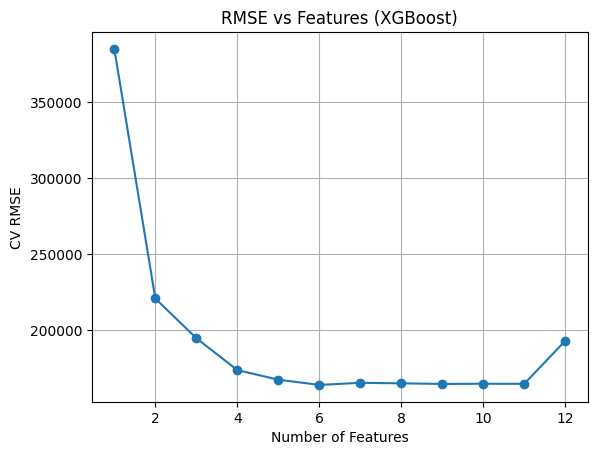

In [7]:
# ===== 6. Backward feature selection =====
X = train_df[all_features]
y = train_df[target_variable]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
history = []

# Đánh giá full model
def default_params():
    return {'tree_method':'hist','random_state':42,'n_jobs':-1,'verbosity':0}

full_pipe = build_pipeline(all_features, params=default_params())
full_rmse = -cross_val_score(full_pipe, X, y, scoring='neg_root_mean_squared_error', cv=kf).mean()
history.append((deepcopy(all_features), full_rmse))

features = deepcopy(all_features)
while len(features) > 1:
    scores = {}
    for feat in features:
        subset = [f for f in features if f != feat]
        rmse = -cross_val_score(build_pipeline(subset, params=default_params()),
                                 X[subset], y, scoring='neg_root_mean_squared_error', cv=kf).mean()
        scores[feat] = rmse
    worst = min(scores, key=scores.get)
    features.remove(worst)
    history.append((features.copy(), scores[worst]))

# Chọn best_feats
best_feats, best_rmse = min(history, key=lambda x: x[1])
print(f"Selected: {best_feats}, RMSE: {best_rmse:.2f}")

# Plot RMSE
df_rmse = pd.DataFrame({'n_features':[len(f) for f,_ in history],'rmse':[r for _,r in history]})
plt.plot(df_rmse['n_features'], df_rmse['rmse'], marker='o')
plt.xlabel('Number of Features')
plt.ylabel('CV RMSE')
plt.title('RMSE vs Features (XGBoost)')
plt.grid(True)
plt.show()


In [8]:
# ===== 7. Optuna tuning XGBoost =====
SEED=42
random.seed(SEED)
np.random.seed(SEED)

X_train_sub = train_df[best_feats]
y_train_sub = train_df[target_variable]

sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(direction='minimize', sampler=sampler)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',300,1500),
        'max_depth': trial.suggest_int('max_depth',3,15),
        'learning_rate': trial.suggest_float('learning_rate',0.01,0.3,log=True),
        'subsample': trial.suggest_float('subsample',0.5,1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.5,1.0),
        'reg_alpha': trial.suggest_float('reg_alpha',0.0,5.0),
        'reg_lambda': trial.suggest_float('reg_lambda',0.0,5.0),
        'tree_method': 'hist',
        'random_state': SEED,
        'n_jobs':1,
        'verbosity':0
    }
    pipe = build_pipeline(best_feats, params=params)
    rmse = -cross_val_score(pipe, X_train_sub, y_train_sub,
                             scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1).mean()
    return rmse

study.optimize(objective, n_trials=100, show_progress_bar=True)
print('Best RMSE:',round(study.best_value,2))
print('Best params:',study.best_params)

[I 2025-06-17 12:06:32,048] A new study created in memory with name: no-name-e6219e14-b1f0-48da-824d-978fb36c9f4b
Best trial: 0. Best value: 172374:   1%|          | 1/100 [00:25<41:51, 25.37s/it]

[I 2025-06-17 12:06:57,427] Trial 0 finished with value: 172374.4137530231 and parameters: {'n_estimators': 749, 'max_depth': 15, 'learning_rate': 0.1205712628744377, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'reg_alpha': 0.7799726016810132, 'reg_lambda': 0.2904180608409973}. Best is trial 0 with value: 172374.4137530231.


Best trial: 0. Best value: 172374:   2%|▏         | 2/100 [00:48<39:00, 23.88s/it]

[I 2025-06-17 12:07:20,262] Trial 1 finished with value: 175631.69240312063 and parameters: {'n_estimators': 1340, 'max_depth': 10, 'learning_rate': 0.11114989443094977, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'reg_alpha': 4.162213204002109, 'reg_lambda': 1.0616955533913808}. Best is trial 0 with value: 172374.4137530231.


Best trial: 2. Best value: 169341:   3%|▎         | 3/100 [00:51<23:21, 14.44s/it]

[I 2025-06-17 12:07:23,483] Trial 2 finished with value: 169340.95532733982 and parameters: {'n_estimators': 518, 'max_depth': 5, 'learning_rate': 0.028145092716060652, 'subsample': 0.762378215816119, 'colsample_bytree': 0.7159725093210578, 'reg_alpha': 1.4561457009902097, 'reg_lambda': 3.0592644736118975}. Best is trial 2 with value: 169340.95532733982.


Best trial: 3. Best value: 163427:   4%|▍         | 4/100 [00:55<16:15, 10.16s/it]

[I 2025-06-17 12:07:27,083] Trial 3 finished with value: 163427.34890703464 and parameters: {'n_estimators': 467, 'max_depth': 6, 'learning_rate': 0.03476649150592621, 'subsample': 0.728034992108518, 'colsample_bytree': 0.8925879806965068, 'reg_alpha': 0.9983689107917987, 'reg_lambda': 2.571172192068058}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:   5%|▌         | 5/100 [00:59<12:44,  8.05s/it]

[I 2025-06-17 12:07:31,378] Trial 4 finished with value: 175851.17180542953 and parameters: {'n_estimators': 1011, 'max_depth': 3, 'learning_rate': 0.07896186801026692, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'reg_alpha': 4.7444276862666666, 'reg_lambda': 4.828160165372797}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:   6%|▌         | 6/100 [01:07<12:31,  7.99s/it]

[I 2025-06-17 12:07:39,259] Trial 5 finished with value: 163973.01260352373 and parameters: {'n_estimators': 1270, 'max_depth': 6, 'learning_rate': 0.013940346079873234, 'subsample': 0.8421165132560784, 'colsample_bytree': 0.7200762468698007, 'reg_alpha': 0.6101911742238941, 'reg_lambda': 2.475884550556351}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:   7%|▋         | 7/100 [01:14<11:48,  7.62s/it]

[I 2025-06-17 12:07:46,113] Trial 6 finished with value: 168198.46169485897 and parameters: {'n_estimators': 341, 'max_depth': 14, 'learning_rate': 0.024112898115291985, 'subsample': 0.831261142176991, 'colsample_bytree': 0.6558555380447055, 'reg_alpha': 2.600340105889054, 'reg_lambda': 2.7335513967163982}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:   8%|▊         | 8/100 [01:39<20:27, 13.34s/it]

[I 2025-06-17 12:08:11,694] Trial 7 finished with value: 170098.81861188315 and parameters: {'n_estimators': 522, 'max_depth': 15, 'learning_rate': 0.13962563737015762, 'subsample': 0.9697494707820946, 'colsample_bytree': 0.9474136752138245, 'reg_alpha': 2.9894998940554256, 'reg_lambda': 4.609371175115584}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:   9%|▉         | 9/100 [01:41<14:59,  9.89s/it]

[I 2025-06-17 12:08:13,997] Trial 8 finished with value: 192774.5184142717 and parameters: {'n_estimators': 406, 'max_depth': 5, 'learning_rate': 0.011662890273931383, 'subsample': 0.6626651653816322, 'colsample_bytree': 0.6943386448447411, 'reg_alpha': 1.3567451588694794, 'reg_lambda': 4.143687545759647}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:  10%|█         | 10/100 [01:46<12:30,  8.34s/it]

[I 2025-06-17 12:08:18,855] Trial 9 finished with value: 165619.99588767436 and parameters: {'n_estimators': 728, 'max_depth': 6, 'learning_rate': 0.06333268775321843, 'subsample': 0.5704621124873813, 'colsample_bytree': 0.9010984903770198, 'reg_alpha': 0.3727532183988541, 'reg_lambda': 4.9344346830025865}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:  11%|█         | 11/100 [02:02<15:40, 10.57s/it]

[I 2025-06-17 12:08:34,493] Trial 10 finished with value: 174758.69672252613 and parameters: {'n_estimators': 916, 'max_depth': 10, 'learning_rate': 0.2704729722717779, 'subsample': 0.673425445703311, 'colsample_bytree': 0.8369860450173899, 'reg_alpha': 1.9014648012590543, 'reg_lambda': 1.7157302423117495}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:  12%|█▏        | 12/100 [02:14<16:14, 11.07s/it]

[I 2025-06-17 12:08:46,716] Trial 11 finished with value: 165234.08035559478 and parameters: {'n_estimators': 1454, 'max_depth': 8, 'learning_rate': 0.010179205671557655, 'subsample': 0.9153368210114128, 'colsample_bytree': 0.8087272364965106, 'reg_alpha': 0.13332092059130163, 'reg_lambda': 3.4286947897877846}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:  13%|█▎        | 13/100 [02:26<16:20, 11.27s/it]

[I 2025-06-17 12:08:58,429] Trial 12 finished with value: 163502.8312453526 and parameters: {'n_estimators': 1203, 'max_depth': 8, 'learning_rate': 0.025622896109281097, 'subsample': 0.8725081763159884, 'colsample_bytree': 0.8037518030873996, 'reg_alpha': 1.071858177994055, 'reg_lambda': 2.055591414538395}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:  14%|█▍        | 14/100 [02:37<16:16, 11.35s/it]

[I 2025-06-17 12:09:09,986] Trial 13 finished with value: 164158.49587092578 and parameters: {'n_estimators': 1128, 'max_depth': 8, 'learning_rate': 0.03326664067582645, 'subsample': 0.898539639582001, 'colsample_bytree': 0.8343128947820315, 'reg_alpha': 1.860854659284155, 'reg_lambda': 1.7500353081879891}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:  15%|█▌        | 15/100 [03:08<24:13, 17.10s/it]

[I 2025-06-17 12:09:40,401] Trial 14 finished with value: 168718.6970046737 and parameters: {'n_estimators': 1105, 'max_depth': 12, 'learning_rate': 0.04111520999157098, 'subsample': 0.7084623041637503, 'colsample_bytree': 0.889137179149762, 'reg_alpha': 3.3170321430599126, 'reg_lambda': 2.00477984841022}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:  16%|█▌        | 16/100 [03:10<17:49, 12.73s/it]

[I 2025-06-17 12:09:42,983] Trial 15 finished with value: 199356.46808788533 and parameters: {'n_estimators': 755, 'max_depth': 3, 'learning_rate': 0.02018204461929636, 'subsample': 0.9933547345588543, 'colsample_bytree': 0.7633705661124045, 'reg_alpha': 1.1675885711691942, 'reg_lambda': 3.677218623568558}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:  17%|█▋        | 17/100 [03:23<17:37, 12.74s/it]

[I 2025-06-17 12:09:55,740] Trial 16 finished with value: 167864.32976288843 and parameters: {'n_estimators': 1237, 'max_depth': 8, 'learning_rate': 0.04657370744630154, 'subsample': 0.7450077368596204, 'colsample_bytree': 0.8933139358849993, 'reg_alpha': 1.8089282629243613, 'reg_lambda': 0.8008502129274977}. Best is trial 3 with value: 163427.34890703464.


Best trial: 3. Best value: 163427:  18%|█▊        | 18/100 [03:35<17:11, 12.58s/it]

[I 2025-06-17 12:10:07,942] Trial 17 finished with value: 164682.66790080513 and parameters: {'n_estimators': 606, 'max_depth': 12, 'learning_rate': 0.01943078538113009, 'subsample': 0.8805304594988683, 'colsample_bytree': 0.7808613016201686, 'reg_alpha': 0.02370059826544635, 'reg_lambda': 2.1663945976111982}. Best is trial 3 with value: 163427.34890703464.


Best trial: 18. Best value: 162814:  19%|█▉        | 19/100 [03:44<15:12, 11.27s/it]

[I 2025-06-17 12:10:16,153] Trial 18 finished with value: 162814.28061053256 and parameters: {'n_estimators': 882, 'max_depth': 7, 'learning_rate': 0.017700946614733298, 'subsample': 0.7842442870231159, 'colsample_bytree': 0.6548503898583582, 'reg_alpha': 2.2803952168795547, 'reg_lambda': 1.2907466747202678}. Best is trial 18 with value: 162814.28061053256.


Best trial: 18. Best value: 162814:  20%|██        | 20/100 [03:50<12:53,  9.67s/it]

[I 2025-06-17 12:10:22,107] Trial 19 finished with value: 164879.24408086034 and parameters: {'n_estimators': 873, 'max_depth': 6, 'learning_rate': 0.016597069467878096, 'subsample': 0.6446806235410717, 'colsample_bytree': 0.6256429136924428, 'reg_alpha': 3.492882750794808, 'reg_lambda': 1.2463851220732032}. Best is trial 18 with value: 162814.28061053256.


Best trial: 18. Best value: 162814:  21%|██        | 21/100 [03:53<10:22,  7.88s/it]

[I 2025-06-17 12:10:25,816] Trial 20 finished with value: 163941.34957917655 and parameters: {'n_estimators': 608, 'max_depth': 5, 'learning_rate': 0.0667070891253956, 'subsample': 0.7614432106084573, 'colsample_bytree': 0.6188484938305487, 'reg_alpha': 2.3467313388179805, 'reg_lambda': 0.08379776614494983}. Best is trial 18 with value: 162814.28061053256.


Best trial: 18. Best value: 162814:  22%|██▏       | 22/100 [04:05<11:46,  9.05s/it]

[I 2025-06-17 12:10:37,601] Trial 21 finished with value: 164478.72918687513 and parameters: {'n_estimators': 1469, 'max_depth': 7, 'learning_rate': 0.03679085830787127, 'subsample': 0.8220966292955116, 'colsample_bytree': 0.8407434980706122, 'reg_alpha': 0.9719031879363003, 'reg_lambda': 1.3975762139560741}. Best is trial 18 with value: 162814.28061053256.


Best trial: 18. Best value: 162814:  23%|██▎       | 23/100 [04:23<14:59, 11.69s/it]

[I 2025-06-17 12:10:55,432] Trial 22 finished with value: 166287.33717392478 and parameters: {'n_estimators': 945, 'max_depth': 10, 'learning_rate': 0.028135882603839844, 'subsample': 0.7109633853906804, 'colsample_bytree': 0.9383006162373655, 'reg_alpha': 2.587721423228161, 'reg_lambda': 2.6259756613482512}. Best is trial 18 with value: 162814.28061053256.


Best trial: 18. Best value: 162814:  24%|██▍       | 24/100 [04:40<16:42, 13.19s/it]

[I 2025-06-17 12:11:12,139] Trial 23 finished with value: 165929.4018026772 and parameters: {'n_estimators': 1186, 'max_depth': 9, 'learning_rate': 0.015149617067390576, 'subsample': 0.9301625544211866, 'colsample_bytree': 0.6593712979980785, 'reg_alpha': 2.235511307367605, 'reg_lambda': 0.8305335861042906}. Best is trial 18 with value: 162814.28061053256.


Best trial: 24. Best value: 162561:  25%|██▌       | 25/100 [04:53<16:32, 13.24s/it]

[I 2025-06-17 12:11:25,483] Trial 24 finished with value: 162560.89796262508 and parameters: {'n_estimators': 1352, 'max_depth': 7, 'learning_rate': 0.023233598185867295, 'subsample': 0.79852233751972, 'colsample_bytree': 0.7844802957196509, 'reg_alpha': 1.509619054420127, 'reg_lambda': 2.1463066919314597}. Best is trial 24 with value: 162560.89796262508.


Best trial: 24. Best value: 162561:  26%|██▌       | 26/100 [04:59<13:49, 11.20s/it]

[I 2025-06-17 12:11:31,946] Trial 25 finished with value: 164285.8182938026 and parameters: {'n_estimators': 1336, 'max_depth': 4, 'learning_rate': 0.04942805001894651, 'subsample': 0.7226922595985295, 'colsample_bytree': 0.7366053683653675, 'reg_alpha': 1.708751158066085, 'reg_lambda': 3.0705754532335177}. Best is trial 24 with value: 162560.89796262508.


Best trial: 24. Best value: 162561:  27%|██▋       | 27/100 [05:06<11:50,  9.73s/it]

[I 2025-06-17 12:11:38,229] Trial 26 finished with value: 167012.01685037182 and parameters: {'n_estimators': 1046, 'max_depth': 7, 'learning_rate': 0.020805926526331273, 'subsample': 0.7837540911518199, 'colsample_bytree': 0.535321557171029, 'reg_alpha': 2.9304675249551124, 'reg_lambda': 1.6374026300242783}. Best is trial 24 with value: 162560.89796262508.


Best trial: 27. Best value: 162066:  28%|██▊       | 28/100 [05:12<10:22,  8.64s/it]

[I 2025-06-17 12:11:44,339] Trial 27 finished with value: 162065.69258882094 and parameters: {'n_estimators': 849, 'max_depth': 7, 'learning_rate': 0.032164074766895846, 'subsample': 0.7924882381720401, 'colsample_bytree': 0.6767717948161132, 'reg_alpha': 2.2541148807758353, 'reg_lambda': 0.5365790663871395}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  29%|██▉       | 29/100 [05:22<10:42,  9.05s/it]

[I 2025-06-17 12:11:54,344] Trial 28 finished with value: 164932.42973937694 and parameters: {'n_estimators': 855, 'max_depth': 9, 'learning_rate': 0.013107551595795509, 'subsample': 0.8501191485755071, 'colsample_bytree': 0.674178898866218, 'reg_alpha': 2.139314267454472, 'reg_lambda': 0.45999899928139076}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  30%|███       | 30/100 [05:27<09:19,  7.99s/it]

[I 2025-06-17 12:11:59,856] Trial 29 finished with value: 163172.93411459547 and parameters: {'n_estimators': 768, 'max_depth': 7, 'learning_rate': 0.016755813147372893, 'subsample': 0.8056083961734215, 'colsample_bytree': 0.5783743051085927, 'reg_alpha': 3.745147170134978, 'reg_lambda': 0.4317768355271304}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  31%|███       | 31/100 [05:31<07:46,  6.76s/it]

[I 2025-06-17 12:12:03,734] Trial 30 finished with value: 172536.79806291414 and parameters: {'n_estimators': 673, 'max_depth': 4, 'learning_rate': 0.024305553271849394, 'subsample': 0.7882950784233201, 'colsample_bytree': 0.6119024267795282, 'reg_alpha': 2.895805289442188, 'reg_lambda': 0.8981447108197387}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  32%|███▏      | 32/100 [05:38<07:49,  6.90s/it]

[I 2025-06-17 12:12:10,962] Trial 31 finished with value: 162968.36548576364 and parameters: {'n_estimators': 783, 'max_depth': 7, 'learning_rate': 0.016574015677115566, 'subsample': 0.8136811586889814, 'colsample_bytree': 0.5793855835480393, 'reg_alpha': 4.038298469537632, 'reg_lambda': 0.4774241445491822}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  33%|███▎      | 33/100 [05:49<08:56,  8.00s/it]

[I 2025-06-17 12:12:21,542] Trial 32 finished with value: 167499.7197826147 and parameters: {'n_estimators': 854, 'max_depth': 7, 'learning_rate': 0.018224704625990074, 'subsample': 0.784380508601625, 'colsample_bytree': 0.5660245523146539, 'reg_alpha': 4.809752147751411, 'reg_lambda': 0.05781594035837556}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  33%|███▎      | 33/100 [06:18<08:56,  8.00s/it]

[I 2025-06-17 12:12:49,638] Trial 33 finished with value: 168498.94573687154 and parameters: {'n_estimators': 995, 'max_depth': 10, 'learning_rate': 0.02920811245074406, 'subsample': 0.8541808424530724, 'colsample_bytree': 0.5080776131258349, 'reg_alpha': 4.256531530365163, 'reg_lambda': 0.6208333138458424}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  35%|███▌      | 35/100 [06:34<15:59, 14.76s/it]

[I 2025-06-17 12:13:06,433] Trial 34 finished with value: 164787.82575206744 and parameters: {'n_estimators': 832, 'max_depth': 9, 'learning_rate': 0.012264753990031305, 'subsample': 0.8027174437076285, 'colsample_bytree': 0.5870153876977574, 'reg_alpha': 1.4747898982916359, 'reg_lambda': 1.1828476936131205}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  36%|███▌      | 36/100 [06:38<12:26, 11.67s/it]

[I 2025-06-17 12:13:10,900] Trial 35 finished with value: 164115.81724054908 and parameters: {'n_estimators': 667, 'max_depth': 6, 'learning_rate': 0.022126714864452512, 'subsample': 0.7586735036905049, 'colsample_bytree': 0.706391357420115, 'reg_alpha': 2.716668352917556, 'reg_lambda': 1.4839468924407768}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  37%|███▋      | 37/100 [06:43<09:57,  9.48s/it]

[I 2025-06-17 12:13:15,265] Trial 36 finished with value: 163188.982748234 and parameters: {'n_estimators': 798, 'max_depth': 5, 'learning_rate': 0.03287753595012473, 'subsample': 0.6832578534824549, 'colsample_bytree': 0.745816261045849, 'reg_alpha': 4.166954581756276, 'reg_lambda': 0.3251877826160665}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  38%|███▊      | 38/100 [06:49<08:54,  8.63s/it]

[I 2025-06-17 12:13:21,907] Trial 37 finished with value: 163061.860857802 and parameters: {'n_estimators': 961, 'max_depth': 7, 'learning_rate': 0.015262148974315052, 'subsample': 0.8142634472008577, 'colsample_bytree': 0.6847228043112035, 'reg_alpha': 4.507467209721281, 'reg_lambda': 1.108709453079685}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  39%|███▉      | 39/100 [06:53<07:22,  7.25s/it]

[I 2025-06-17 12:13:25,942] Trial 38 finished with value: 164977.9741090616 and parameters: {'n_estimators': 1046, 'max_depth': 4, 'learning_rate': 0.08620027217248684, 'subsample': 0.6145203230726353, 'colsample_bytree': 0.6349882852285255, 'reg_alpha': 3.8099638497743005, 'reg_lambda': 0.6366579514668889}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  40%|████      | 40/100 [06:59<06:54,  6.91s/it]

[I 2025-06-17 12:13:32,062] Trial 39 finished with value: 176794.01128722867 and parameters: {'n_estimators': 696, 'max_depth': 11, 'learning_rate': 0.01018739106267007, 'subsample': 0.746307153324505, 'colsample_bytree': 0.5576053422673289, 'reg_alpha': 2.0594719352374145, 'reg_lambda': 2.3252994633020387}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  41%|████      | 41/100 [07:02<05:36,  5.71s/it]

[I 2025-06-17 12:13:34,960] Trial 40 finished with value: 162519.9500501621 and parameters: {'n_estimators': 595, 'max_depth': 6, 'learning_rate': 0.03920979725159535, 'subsample': 0.8363019009630895, 'colsample_bytree': 0.5993636108361037, 'reg_alpha': 3.2661046667279345, 'reg_lambda': 1.0306014025307058}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  42%|████▏     | 42/100 [07:05<04:41,  4.86s/it]

[I 2025-06-17 12:13:37,851] Trial 41 finished with value: 163028.70593924867 and parameters: {'n_estimators': 598, 'max_depth': 6, 'learning_rate': 0.03974301506904599, 'subsample': 0.84478726621486, 'colsample_bytree': 0.6024341674194963, 'reg_alpha': 3.8344453383561206, 'reg_lambda': 1.0162566823100525}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  43%|████▎     | 43/100 [07:08<03:59,  4.21s/it]

[I 2025-06-17 12:13:40,540] Trial 42 finished with value: 167083.623868811 and parameters: {'n_estimators': 477, 'max_depth': 5, 'learning_rate': 0.028750024087845737, 'subsample': 0.5139388480023125, 'colsample_bytree': 0.6367369643556767, 'reg_alpha': 3.1810816090228973, 'reg_lambda': 0.6919866419979215}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  44%|████▍     | 44/100 [07:14<04:33,  4.88s/it]

[I 2025-06-17 12:13:46,969] Trial 43 finished with value: 162776.21314976458 and parameters: {'n_estimators': 551, 'max_depth': 8, 'learning_rate': 0.05865974727925997, 'subsample': 0.8767735907977774, 'colsample_bytree': 0.7208841573710365, 'reg_alpha': 2.4574235167832685, 'reg_lambda': 1.3612722468196745}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  45%|████▌     | 45/100 [07:18<04:03,  4.43s/it]

[I 2025-06-17 12:13:50,372] Trial 44 finished with value: 162862.0297027423 and parameters: {'n_estimators': 319, 'max_depth': 8, 'learning_rate': 0.060359699589210156, 'subsample': 0.9299254849529391, 'colsample_bytree': 0.7212807810494173, 'reg_alpha': 2.441649985856345, 'reg_lambda': 1.4195512781816109}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  46%|████▌     | 46/100 [07:22<03:51,  4.29s/it]

[I 2025-06-17 12:13:54,333] Trial 45 finished with value: 168548.86690346999 and parameters: {'n_estimators': 401, 'max_depth': 9, 'learning_rate': 0.11227425172114686, 'subsample': 0.8671096056538419, 'colsample_bytree': 0.6577660004937238, 'reg_alpha': 1.5794591695217282, 'reg_lambda': 1.9598311548968501}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  47%|████▋     | 47/100 [07:24<03:18,  3.75s/it]

[I 2025-06-17 12:13:56,797] Trial 46 finished with value: 165373.40327563262 and parameters: {'n_estimators': 505, 'max_depth': 6, 'learning_rate': 0.07977155155378875, 'subsample': 0.9027687930346092, 'colsample_bytree': 0.6930462102049855, 'reg_alpha': 2.700326328588038, 'reg_lambda': 2.869744517018346}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  48%|████▊     | 48/100 [07:29<03:31,  4.07s/it]

[I 2025-06-17 12:14:01,617] Trial 47 finished with value: 162857.18602471158 and parameters: {'n_estimators': 570, 'max_depth': 8, 'learning_rate': 0.046876306891290326, 'subsample': 0.9532007180062511, 'colsample_bytree': 0.7907659054616606, 'reg_alpha': 1.9958101482854032, 'reg_lambda': 1.8836391073459111}. Best is trial 27 with value: 162065.69258882094.


Best trial: 27. Best value: 162066:  49%|████▉     | 49/100 [07:43<06:02,  7.11s/it]

[I 2025-06-17 12:14:15,821] Trial 48 finished with value: 168099.10325623248 and parameters: {'n_estimators': 1374, 'max_depth': 8, 'learning_rate': 0.1999703573397433, 'subsample': 0.8351376187275387, 'colsample_bytree': 0.7242624729978754, 'reg_alpha': 0.6275692804682014, 'reg_lambda': 1.5793746362888896}. Best is trial 27 with value: 162065.69258882094.


Best trial: 49. Best value: 161087:  50%|█████     | 50/100 [07:46<04:53,  5.88s/it]

[I 2025-06-17 12:14:18,836] Trial 49 finished with value: 161087.13355810192 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.09699713612032222, 'subsample': 0.8828620382293353, 'colsample_bytree': 0.7693566764889106, 'reg_alpha': 1.2977122058652388, 'reg_lambda': 1.2053735499925267}. Best is trial 49 with value: 161087.13355810192.


Best trial: 49. Best value: 161087:  51%|█████     | 51/100 [07:49<03:56,  4.82s/it]

[I 2025-06-17 12:14:21,185] Trial 50 finished with value: 164817.67549058865 and parameters: {'n_estimators': 417, 'max_depth': 6, 'learning_rate': 0.1599182007872716, 'subsample': 0.8863811221078931, 'colsample_bytree': 0.7613068772506042, 'reg_alpha': 0.7941775685320547, 'reg_lambda': 0.9176779888777751}. Best is trial 49 with value: 161087.13355810192.


Best trial: 49. Best value: 161087:  52%|█████▏    | 52/100 [07:52<03:33,  4.45s/it]

[I 2025-06-17 12:14:24,757] Trial 51 finished with value: 162273.32344371203 and parameters: {'n_estimators': 551, 'max_depth': 7, 'learning_rate': 0.0931200669944004, 'subsample': 0.7745236716746247, 'colsample_bytree': 0.7667390671679631, 'reg_alpha': 1.2266728951175558, 'reg_lambda': 1.3760073016965473}. Best is trial 49 with value: 161087.13355810192.


Best trial: 49. Best value: 161087:  53%|█████▎    | 53/100 [07:55<03:11,  4.07s/it]

[I 2025-06-17 12:14:27,946] Trial 52 finished with value: 162814.24297326047 and parameters: {'n_estimators': 550, 'max_depth': 6, 'learning_rate': 0.13020054955464955, 'subsample': 0.8671042976768036, 'colsample_bytree': 0.861154708615052, 'reg_alpha': 1.2812426460423385, 'reg_lambda': 2.242031287869213}. Best is trial 49 with value: 161087.13355810192.


Best trial: 49. Best value: 161087:  54%|█████▍    | 54/100 [07:57<02:34,  3.35s/it]

[I 2025-06-17 12:14:29,627] Trial 53 finished with value: 162248.3898305254 and parameters: {'n_estimators': 368, 'max_depth': 5, 'learning_rate': 0.09517876209068665, 'subsample': 0.7714678096316656, 'colsample_bytree': 0.7732213287193495, 'reg_alpha': 1.6031901537952205, 'reg_lambda': 1.0397666777691645}. Best is trial 49 with value: 161087.13355810192.


Best trial: 54. Best value: 160785:  55%|█████▌    | 55/100 [07:59<02:13,  2.97s/it]

[I 2025-06-17 12:14:31,717] Trial 54 finished with value: 160784.57972978678 and parameters: {'n_estimators': 367, 'max_depth': 5, 'learning_rate': 0.09746859061480773, 'subsample': 0.7719603400963557, 'colsample_bytree': 0.7765896528214394, 'reg_alpha': 1.635927891873417, 'reg_lambda': 1.830240172192831}. Best is trial 54 with value: 160784.57972978678.


Best trial: 54. Best value: 160785:  56%|█████▌    | 56/100 [08:01<01:52,  2.55s/it]

[I 2025-06-17 12:14:33,284] Trial 55 finished with value: 162667.52409329268 and parameters: {'n_estimators': 367, 'max_depth': 4, 'learning_rate': 0.09855727195556756, 'subsample': 0.76814108097696, 'colsample_bytree': 0.812962563005162, 'reg_alpha': 0.904748355156296, 'reg_lambda': 1.741102351857123}. Best is trial 54 with value: 160784.57972978678.


Best trial: 56. Best value: 160350:  57%|█████▋    | 57/100 [08:04<01:54,  2.67s/it]

[I 2025-06-17 12:14:36,228] Trial 56 finished with value: 160350.4069917019 and parameters: {'n_estimators': 445, 'max_depth': 5, 'learning_rate': 0.06910847031068042, 'subsample': 0.7396478621742751, 'colsample_bytree': 0.7764031425037194, 'reg_alpha': 1.2328145497708047, 'reg_lambda': 1.1294248916810838}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  58%|█████▊    | 58/100 [08:07<02:06,  3.01s/it]

[I 2025-06-17 12:14:40,022] Trial 57 finished with value: 166704.9369580652 and parameters: {'n_estimators': 448, 'max_depth': 3, 'learning_rate': 0.15297933840086994, 'subsample': 0.7414556975399906, 'colsample_bytree': 0.7669064637546827, 'reg_alpha': 1.2468507493600762, 'reg_lambda': 1.188973894581797}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  59%|█████▉    | 59/100 [08:10<02:00,  2.95s/it]

[I 2025-06-17 12:14:42,824] Trial 58 finished with value: 165412.01810204837 and parameters: {'n_estimators': 352, 'max_depth': 5, 'learning_rate': 0.0904171039177089, 'subsample': 0.7057109003808921, 'colsample_bytree': 0.8012316078924798, 'reg_alpha': 1.6644287941584577, 'reg_lambda': 1.8553545931625848}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  60%|██████    | 60/100 [08:13<01:52,  2.82s/it]

[I 2025-06-17 12:14:45,364] Trial 59 finished with value: 164565.21919162187 and parameters: {'n_estimators': 308, 'max_depth': 5, 'learning_rate': 0.06961033734987596, 'subsample': 0.6899138778990166, 'colsample_bytree': 0.8250736302832793, 'reg_alpha': 0.28211692666379795, 'reg_lambda': 0.20743482881710218}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  61%|██████    | 61/100 [08:15<01:47,  2.75s/it]

[I 2025-06-17 12:14:47,947] Trial 60 finished with value: 161775.9001071866 and parameters: {'n_estimators': 435, 'max_depth': 4, 'learning_rate': 0.10602463139866992, 'subsample': 0.7286593142411119, 'colsample_bytree': 0.7716988236014114, 'reg_alpha': 0.5132747378772861, 'reg_lambda': 0.7468307005925638}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  62%|██████▏   | 62/100 [08:18<01:39,  2.61s/it]

[I 2025-06-17 12:14:50,237] Trial 61 finished with value: 169706.73343995833 and parameters: {'n_estimators': 447, 'max_depth': 3, 'learning_rate': 0.10176921307159113, 'subsample': 0.7363268765663773, 'colsample_bytree': 0.7511254618308076, 'reg_alpha': 0.5832427026864287, 'reg_lambda': 0.6791048591308338}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  63%|██████▎   | 63/100 [08:20<01:32,  2.50s/it]

[I 2025-06-17 12:14:52,486] Trial 62 finished with value: 164952.92022603084 and parameters: {'n_estimators': 395, 'max_depth': 4, 'learning_rate': 0.07262514306881993, 'subsample': 0.7751138516414797, 'colsample_bytree': 0.8497273543054523, 'reg_alpha': 1.1119014734112722, 'reg_lambda': 1.5531745082568238}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  64%|██████▍   | 64/100 [08:23<01:39,  2.78s/it]

[I 2025-06-17 12:14:55,899] Trial 63 finished with value: 163781.93777197803 and parameters: {'n_estimators': 507, 'max_depth': 5, 'learning_rate': 0.12340405827246266, 'subsample': 0.6553782315168388, 'colsample_bytree': 0.7678212829974453, 'reg_alpha': 1.359777781473916, 'reg_lambda': 0.8117231633725739}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  65%|██████▌   | 65/100 [08:26<01:31,  2.62s/it]

[I 2025-06-17 12:14:58,144] Trial 64 finished with value: 164896.55602891668 and parameters: {'n_estimators': 367, 'max_depth': 4, 'learning_rate': 0.10198821900159871, 'subsample': 0.7242045430436659, 'colsample_bytree': 0.7878266186610259, 'reg_alpha': 0.4035459041952567, 'reg_lambda': 1.0248793971203884}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  66%|██████▌   | 66/100 [08:28<01:26,  2.56s/it]

[I 2025-06-17 12:15:00,559] Trial 65 finished with value: 173809.95280775393 and parameters: {'n_estimators': 480, 'max_depth': 3, 'learning_rate': 0.0784316600059159, 'subsample': 0.7534002970672016, 'colsample_bytree': 0.7359779754238647, 'reg_alpha': 1.8189357542488955, 'reg_lambda': 1.2994981301785127}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  67%|██████▋   | 67/100 [08:31<01:26,  2.63s/it]

[I 2025-06-17 12:15:03,347] Trial 66 finished with value: 166242.01394412745 and parameters: {'n_estimators': 418, 'max_depth': 5, 'learning_rate': 0.11329759341518096, 'subsample': 0.6981353840316741, 'colsample_bytree': 0.874024616964081, 'reg_alpha': 1.0020987008101845, 'reg_lambda': 4.418513507125934}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  68%|██████▊   | 68/100 [08:49<03:58,  7.44s/it]

[I 2025-06-17 12:15:22,016] Trial 67 finished with value: 172431.23011863668 and parameters: {'n_estimators': 342, 'max_depth': 15, 'learning_rate': 0.17739225782490042, 'subsample': 0.7682044156089735, 'colsample_bytree': 0.8127687057143201, 'reg_alpha': 0.7833688187748691, 'reg_lambda': 0.23654418255690024}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  69%|██████▉   | 69/100 [08:51<02:58,  5.77s/it]

[I 2025-06-17 12:15:23,896] Trial 68 finished with value: 168392.1943434101 and parameters: {'n_estimators': 308, 'max_depth': 4, 'learning_rate': 0.05572929223856109, 'subsample': 0.7253894598506265, 'colsample_bytree': 0.8250259832899159, 'reg_alpha': 1.3557808798352184, 'reg_lambda': 0.8645053176302043}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  70%|███████   | 70/100 [08:54<02:23,  4.80s/it]

[I 2025-06-17 12:15:26,422] Trial 69 finished with value: 163630.25505060627 and parameters: {'n_estimators': 383, 'max_depth': 5, 'learning_rate': 0.08756983980926318, 'subsample': 0.7948788293670763, 'colsample_bytree': 0.776584483898819, 'reg_alpha': 1.6412738039507084, 'reg_lambda': 0.5705164923758039}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  71%|███████   | 71/100 [09:11<04:10,  8.62s/it]

[I 2025-06-17 12:15:43,967] Trial 70 finished with value: 171338.9848399144 and parameters: {'n_estimators': 640, 'max_depth': 13, 'learning_rate': 0.13620769740622488, 'subsample': 0.8215443513187936, 'colsample_bytree': 0.7057406791833376, 'reg_alpha': 1.1729765973534645, 'reg_lambda': 2.4469281906814633}. Best is trial 56 with value: 160350.4069917019.


Best trial: 56. Best value: 160350:  72%|███████▏  | 72/100 [09:14<03:10,  6.82s/it]

[I 2025-06-17 12:15:46,585] Trial 71 finished with value: 161321.3112250375 and parameters: {'n_estimators': 452, 'max_depth': 6, 'learning_rate': 0.05092224507390447, 'subsample': 0.8312510120463952, 'colsample_bytree': 0.751094292412047, 'reg_alpha': 1.8826049092509436, 'reg_lambda': 1.024510556075156}. Best is trial 56 with value: 160350.4069917019.


Best trial: 72. Best value: 160040:  73%|███████▎  | 73/100 [09:17<02:30,  5.59s/it]

[I 2025-06-17 12:15:49,299] Trial 72 finished with value: 160039.65019793314 and parameters: {'n_estimators': 446, 'max_depth': 6, 'learning_rate': 0.07721263006761755, 'subsample': 0.7754961067405847, 'colsample_bytree': 0.7514374100364896, 'reg_alpha': 1.8189375724461416, 'reg_lambda': 1.1806689755212478}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  74%|███████▍  | 74/100 [09:19<02:00,  4.65s/it]

[I 2025-06-17 12:15:51,770] Trial 73 finished with value: 162132.98993964394 and parameters: {'n_estimators': 438, 'max_depth': 6, 'learning_rate': 0.051242537797925064, 'subsample': 0.7168395422340963, 'colsample_bytree': 0.7418736240379697, 'reg_alpha': 1.9386016964820645, 'reg_lambda': 1.1487681686969484}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  75%|███████▌  | 75/100 [09:22<01:40,  4.02s/it]

[I 2025-06-17 12:15:54,323] Trial 74 finished with value: 162118.1194281434 and parameters: {'n_estimators': 442, 'max_depth': 6, 'learning_rate': 0.05381584138108561, 'subsample': 0.7151133603860067, 'colsample_bytree': 0.7496194707956654, 'reg_alpha': 1.908338422885777, 'reg_lambda': 0.40908411067907546}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  76%|███████▌  | 76/100 [09:24<01:26,  3.59s/it]

[I 2025-06-17 12:15:56,911] Trial 75 finished with value: 162793.20229170378 and parameters: {'n_estimators': 481, 'max_depth': 6, 'learning_rate': 0.06499622821133787, 'subsample': 0.7318591148072773, 'colsample_bytree': 0.7538773050697257, 'reg_alpha': 2.1662365623216138, 'reg_lambda': 0.4187795681497526}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  77%|███████▋  | 77/100 [09:28<01:24,  3.66s/it]

[I 2025-06-17 12:16:00,713] Trial 76 finished with value: 161690.86606768967 and parameters: {'n_estimators': 531, 'max_depth': 7, 'learning_rate': 0.044333557665611145, 'subsample': 0.6695248229522284, 'colsample_bytree': 0.7973050131364792, 'reg_alpha': 1.7816628850903447, 'reg_lambda': 0.7421633798833644}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  78%|███████▊  | 78/100 [09:32<01:18,  3.57s/it]

[I 2025-06-17 12:16:04,095] Trial 77 finished with value: 162008.84646358909 and parameters: {'n_estimators': 525, 'max_depth': 7, 'learning_rate': 0.04265739400609543, 'subsample': 0.6111082258172824, 'colsample_bytree': 0.7987960758477083, 'reg_alpha': 1.7811532970418535, 'reg_lambda': 0.7636411906747559}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  79%|███████▉  | 79/100 [09:35<01:13,  3.49s/it]

[I 2025-06-17 12:16:07,397] Trial 78 finished with value: 162115.1989483939 and parameters: {'n_estimators': 520, 'max_depth': 7, 'learning_rate': 0.04455543892784461, 'subsample': 0.6238657091705485, 'colsample_bytree': 0.7972360251527342, 'reg_alpha': 1.4483191541306946, 'reg_lambda': 0.7598709547369719}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  80%|████████  | 80/100 [09:37<01:03,  3.19s/it]

[I 2025-06-17 12:16:09,880] Trial 79 finished with value: 163893.45688046847 and parameters: {'n_estimators': 502, 'max_depth': 5, 'learning_rate': 0.0734368665610794, 'subsample': 0.5386162424742109, 'colsample_bytree': 0.8286122748268041, 'reg_alpha': 1.7529904778806542, 'reg_lambda': 0.9694968362078634}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  81%|████████  | 81/100 [09:41<01:06,  3.48s/it]

[I 2025-06-17 12:16:14,039] Trial 80 finished with value: 162547.4554120411 and parameters: {'n_estimators': 633, 'max_depth': 7, 'learning_rate': 0.03658962460932888, 'subsample': 0.6712694756291727, 'colsample_bytree': 0.7316703149833343, 'reg_alpha': 1.4938625449675091, 'reg_lambda': 1.2597047673415829}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  82%|████████▏ | 82/100 [09:45<01:01,  3.42s/it]

[I 2025-06-17 12:16:17,310] Trial 81 finished with value: 166163.2380691367 and parameters: {'n_estimators': 419, 'max_depth': 7, 'learning_rate': 0.07766371672281716, 'subsample': 0.6078327030565549, 'colsample_bytree': 0.7844662200892372, 'reg_alpha': 2.1008764809511487, 'reg_lambda': 0.5126202409493884}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  83%|████████▎ | 83/100 [09:49<01:00,  3.58s/it]

[I 2025-06-17 12:16:21,264] Trial 82 finished with value: 164165.49473647424 and parameters: {'n_estimators': 719, 'max_depth': 6, 'learning_rate': 0.04588242406129731, 'subsample': 0.582636503051005, 'colsample_bytree': 0.8107490517109806, 'reg_alpha': 2.375424465003843, 'reg_lambda': 0.13803816391252322}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  84%|████████▍ | 84/100 [09:52<00:55,  3.48s/it]

[I 2025-06-17 12:16:24,504] Trial 83 finished with value: 160588.021515681 and parameters: {'n_estimators': 471, 'max_depth': 7, 'learning_rate': 0.03079776770107542, 'subsample': 0.6483674008137338, 'colsample_bytree': 0.7943349939734277, 'reg_alpha': 2.255516911608571, 'reg_lambda': 0.7576989353974609}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  85%|████████▌ | 85/100 [09:56<00:52,  3.53s/it]

[I 2025-06-17 12:16:28,157] Trial 84 finished with value: 162163.4821990112 and parameters: {'n_estimators': 464, 'max_depth': 8, 'learning_rate': 0.04174491183165303, 'subsample': 0.6514665268354598, 'colsample_bytree': 0.8478556857078376, 'reg_alpha': 1.8563591417414735, 'reg_lambda': 0.7526141515837549}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  86%|████████▌ | 86/100 [09:59<00:47,  3.39s/it]

[I 2025-06-17 12:16:31,223] Trial 85 finished with value: 162619.95931630675 and parameters: {'n_estimators': 534, 'max_depth': 6, 'learning_rate': 0.06018717016502249, 'subsample': 0.6348700920352262, 'colsample_bytree': 0.8010022635038497, 'reg_alpha': 2.010218468719139, 'reg_lambda': 0.9197870095680309}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  87%|████████▋ | 87/100 [10:01<00:41,  3.22s/it]

[I 2025-06-17 12:16:34,055] Trial 86 finished with value: 164692.52907994803 and parameters: {'n_estimators': 484, 'max_depth': 7, 'learning_rate': 0.02653709552743037, 'subsample': 0.6703072262394146, 'colsample_bytree': 0.7083102884705605, 'reg_alpha': 1.7605213973621447, 'reg_lambda': 1.6541170358450346}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  88%|████████▊ | 88/100 [10:04<00:37,  3.12s/it]

[I 2025-06-17 12:16:36,918] Trial 87 finished with value: 167078.96347961918 and parameters: {'n_estimators': 332, 'max_depth': 8, 'learning_rate': 0.08432297056021437, 'subsample': 0.6071816076316909, 'colsample_bytree': 0.7783764575349398, 'reg_alpha': 2.5798869908090736, 'reg_lambda': 1.4901694187259338}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  89%|████████▉ | 89/100 [10:08<00:35,  3.20s/it]

[I 2025-06-17 12:16:40,309] Trial 88 finished with value: 165320.32471233967 and parameters: {'n_estimators': 574, 'max_depth': 5, 'learning_rate': 0.030793867668558416, 'subsample': 0.592148678580885, 'colsample_bytree': 0.7579997965561128, 'reg_alpha': 2.282053671559508, 'reg_lambda': 1.125919121011334}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  90%|█████████ | 90/100 [10:10<00:30,  3.02s/it]

[I 2025-06-17 12:16:42,919] Trial 89 finished with value: 166958.49245826856 and parameters: {'n_estimators': 385, 'max_depth': 4, 'learning_rate': 0.03477516555385408, 'subsample': 0.6865789673935473, 'colsample_bytree': 0.7915536694841931, 'reg_alpha': 1.405822823516972, 'reg_lambda': 0.001090656007078139}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  91%|█████████ | 91/100 [10:13<00:27,  3.02s/it]

[I 2025-06-17 12:16:45,947] Trial 90 finished with value: 161325.36632677892 and parameters: {'n_estimators': 429, 'max_depth': 6, 'learning_rate': 0.04894671032606038, 'subsample': 0.638285363627384, 'colsample_bytree': 0.8205055965646717, 'reg_alpha': 2.1995751171886813, 'reg_lambda': 0.29707993685207074}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  92%|█████████▏| 92/100 [10:16<00:23,  2.97s/it]

[I 2025-06-17 12:16:48,796] Trial 91 finished with value: 161322.72574706917 and parameters: {'n_estimators': 423, 'max_depth': 6, 'learning_rate': 0.04881387791806853, 'subsample': 0.6381690767995775, 'colsample_bytree': 0.8173037945183181, 'reg_alpha': 2.165551282703187, 'reg_lambda': 0.3208264698719137}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  93%|█████████▎| 93/100 [10:19<00:20,  2.89s/it]

[I 2025-06-17 12:16:51,487] Trial 92 finished with value: 160866.3468340742 and parameters: {'n_estimators': 427, 'max_depth': 6, 'learning_rate': 0.0514861732183472, 'subsample': 0.6251632879242497, 'colsample_bytree': 0.8188294522858177, 'reg_alpha': 2.080221041343622, 'reg_lambda': 0.2719191353733267}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  94%|█████████▍| 94/100 [10:22<00:17,  2.85s/it]

[I 2025-06-17 12:16:54,263] Trial 93 finished with value: 160131.69433227173 and parameters: {'n_estimators': 403, 'max_depth': 6, 'learning_rate': 0.05351863146838934, 'subsample': 0.6380926229716157, 'colsample_bytree': 0.8193635182742487, 'reg_alpha': 2.25491909359223, 'reg_lambda': 0.3206854546337961}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  95%|█████████▌| 95/100 [10:25<00:15,  3.02s/it]

[I 2025-06-17 12:16:57,657] Trial 94 finished with value: 162936.91229229694 and parameters: {'n_estimators': 403, 'max_depth': 6, 'learning_rate': 0.050917908412143074, 'subsample': 0.6301525959506059, 'colsample_bytree': 0.8182741017522036, 'reg_alpha': 2.174786197849593, 'reg_lambda': 0.1460539309723808}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  96%|█████████▌| 96/100 [10:28<00:12,  3.02s/it]

[I 2025-06-17 12:17:00,671] Trial 95 finished with value: 164482.43330280023 and parameters: {'n_estimators': 342, 'max_depth': 6, 'learning_rate': 0.06473808325469974, 'subsample': 0.5587210433593487, 'colsample_bytree': 0.8370988130990075, 'reg_alpha': 2.362623613512463, 'reg_lambda': 0.3620078573694475}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  97%|█████████▋| 97/100 [10:31<00:08,  2.90s/it]

[I 2025-06-17 12:17:03,292] Trial 96 finished with value: 164473.73458406128 and parameters: {'n_estimators': 461, 'max_depth': 5, 'learning_rate': 0.05785639345357028, 'subsample': 0.6379841611955178, 'colsample_bytree': 0.9176699923120218, 'reg_alpha': 2.5189914869242114, 'reg_lambda': 0.2906874232182051}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  98%|█████████▊| 98/100 [10:34<00:05,  2.92s/it]

[I 2025-06-17 12:17:06,260] Trial 97 finished with value: 160481.8535611895 and parameters: {'n_estimators': 418, 'max_depth': 6, 'learning_rate': 0.053579884230618297, 'subsample': 0.6463217565641511, 'colsample_bytree': 0.8376278300097207, 'reg_alpha': 2.6899128102046403, 'reg_lambda': 0.5677217657815773}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040:  99%|█████████▉| 99/100 [10:36<00:02,  2.74s/it]

[I 2025-06-17 12:17:08,589] Trial 98 finished with value: 162687.82767983506 and parameters: {'n_estimators': 369, 'max_depth': 6, 'learning_rate': 0.07176387968254656, 'subsample': 0.5932832476398281, 'colsample_bytree': 0.8654626496544957, 'reg_alpha': 2.039265979892404, 'reg_lambda': 0.5885139547050882}. Best is trial 72 with value: 160039.65019793314.


Best trial: 72. Best value: 160040: 100%|██████████| 100/100 [10:38<00:00,  6.39s/it]

[I 2025-06-17 12:17:10,690] Trial 99 finished with value: 164183.78798225825 and parameters: {'n_estimators': 394, 'max_depth': 5, 'learning_rate': 0.05284372008429502, 'subsample': 0.6529012420656924, 'colsample_bytree': 0.8768956046335373, 'reg_alpha': 2.767342076066762, 'reg_lambda': 0.6116618418242799}. Best is trial 72 with value: 160039.65019793314.
Best RMSE: 160039.65
Best params: {'n_estimators': 446, 'max_depth': 6, 'learning_rate': 0.07721263006761755, 'subsample': 0.7754961067405847, 'colsample_bytree': 0.7514374100364896, 'reg_alpha': 1.8189375724461416, 'reg_lambda': 1.1806689755212478}


In [9]:
# ===== 8. Đánh giá trên test =====
pipe_final = build_pipeline(best_feats, params={**study.best_params,'tree_method':'hist','random_state':SEED,'n_jobs':-1,'verbosity':0})
pipe_final.fit(train_df[best_feats], train_df[target_variable])
y_pred = pipe_final.predict(test_df[best_feats])
rmse_test = mean_squared_error(test_df[target_variable], y_pred, squared=False)
print('Test RMSE:',rmse_test)

Test RMSE: 137937.2313699552


In [10]:
# ===== 7b. Chạy lại Optuna và đánh giá với TẤT CẢ feature =====
# Sử dụng all_features thay cho best_feats
pipe_all = build_pipeline(all_features, params={**default_params(), 'n_jobs':1, 'random_state':SEED, 'verbosity':0})
# Tuning trên all_features
study_all = optuna.create_study(direction='minimize', sampler=sampler)
def objective_all(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',300,1500),
        'max_depth': trial.suggest_int('max_depth',3,15),
        'learning_rate': trial.suggest_float('learning_rate',0.01,0.3,log=True),
        'subsample': trial.suggest_float('subsample',0.5,1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.5,1.0),
        'reg_alpha': trial.suggest_float('reg_alpha',0.0,5.0),
        'reg_lambda': trial.suggest_float('reg_lambda',0.0,5.0),
        'tree_method': 'hist',
        'random_state': SEED,
        'n_jobs':1,
        'verbosity':0
    }
    pipe = build_pipeline(all_features, params=params)
    return -cross_val_score(pipe, train_df[all_features], train_df[target_variable], scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1).mean()
study_all.optimize(objective_all, n_trials=100, show_progress_bar=True)
print('All-features RMSE (CV):', round(study_all.best_value,2))


[I 2025-06-17 12:19:39,038] A new study created in memory with name: no-name-6d7a9fcb-70cc-4239-8acf-6b680a546819
Best trial: 0. Best value: 170835:   1%|          | 1/100 [00:07<13:08,  7.96s/it]

[I 2025-06-17 12:19:47,020] Trial 0 finished with value: 170834.79614668322 and parameters: {'n_estimators': 1227, 'max_depth': 5, 'learning_rate': 0.010189592979395137, 'subsample': 0.9077307142274171, 'colsample_bytree': 0.8534286719238086, 'reg_alpha': 3.6450358402049368, 'reg_lambda': 3.8563517334297286}. Best is trial 0 with value: 170834.79614668322.


Best trial: 0. Best value: 170835:   2%|▏         | 2/100 [00:13<10:45,  6.59s/it]

[I 2025-06-17 12:19:52,650] Trial 1 finished with value: 171253.41188942367 and parameters: {'n_estimators': 388, 'max_depth': 7, 'learning_rate': 0.014830392684568025, 'subsample': 0.9315517129377968, 'colsample_bytree': 0.811649063413779, 'reg_alpha': 1.654490124263246, 'reg_lambda': 0.3177917514301182}. Best is trial 0 with value: 170834.79614668322.


Best trial: 0. Best value: 170835:   3%|▎         | 3/100 [00:22<12:30,  7.74s/it]

[I 2025-06-17 12:20:01,763] Trial 2 finished with value: 171847.77027904775 and parameters: {'n_estimators': 673, 'max_depth': 7, 'learning_rate': 0.1195960383019184, 'subsample': 0.8187787356776066, 'colsample_bytree': 0.9436063712881633, 'reg_alpha': 2.3610746258097466, 'reg_lambda': 0.5979712296915085}. Best is trial 0 with value: 170834.79614668322.


Best trial: 0. Best value: 170835:   4%|▍         | 4/100 [01:22<45:32, 28.46s/it]

[I 2025-06-17 12:21:01,994] Trial 3 finished with value: 172605.50901562496 and parameters: {'n_estimators': 1156, 'max_depth': 12, 'learning_rate': 0.06746437142284309, 'subsample': 0.8854835899772805, 'colsample_bytree': 0.7468977981821954, 'reg_alpha': 2.6136641469099704, 'reg_lambda': 2.137705091792748}. Best is trial 0 with value: 170834.79614668322.


Best trial: 0. Best value: 170835:   5%|▌         | 5/100 [01:24<29:49, 18.84s/it]

[I 2025-06-17 12:21:03,744] Trial 4 finished with value: 194432.9603516679 and parameters: {'n_estimators': 330, 'max_depth': 4, 'learning_rate': 0.011128194768838964, 'subsample': 0.8182052056318903, 'colsample_bytree': 0.6571779905381634, 'reg_alpha': 2.542853455823514, 'reg_lambda': 4.537832369630465}. Best is trial 0 with value: 170834.79614668322.


Best trial: 0. Best value: 170835:   6%|▌         | 6/100 [01:32<23:39, 15.10s/it]

[I 2025-06-17 12:21:11,598] Trial 5 finished with value: 173357.2935777971 and parameters: {'n_estimators': 599, 'max_depth': 8, 'learning_rate': 0.1306293138834092, 'subsample': 0.6143990827458112, 'colsample_bytree': 0.5384899549143964, 'reg_alpha': 1.4487572645688402, 'reg_lambda': 0.8061064362700221}. Best is trial 0 with value: 170834.79614668322.


Best trial: 0. Best value: 170835:   7%|▋         | 7/100 [03:05<1:02:36, 40.40s/it]

[I 2025-06-17 12:22:44,068] Trial 6 finished with value: 176454.07884157862 and parameters: {'n_estimators': 1416, 'max_depth': 13, 'learning_rate': 0.08622121759478739, 'subsample': 0.9357302950938589, 'colsample_bytree': 0.9018360384495572, 'reg_alpha': 0.9328502944301792, 'reg_lambda': 4.462794992449889}. Best is trial 0 with value: 170834.79614668322.


Best trial: 0. Best value: 170835:   8%|▊         | 8/100 [03:48<1:03:32, 41.44s/it]

[I 2025-06-17 12:23:27,745] Trial 7 finished with value: 179923.91430923034 and parameters: {'n_estimators': 947, 'max_depth': 13, 'learning_rate': 0.21068591627429098, 'subsample': 0.6590017374859319, 'colsample_bytree': 0.5550259622638384, 'reg_alpha': 1.1396758127097084, 'reg_lambda': 2.1355389431312815}. Best is trial 0 with value: 170834.79614668322.


Best trial: 8. Best value: 166821:   9%|▉         | 9/100 [05:03<1:18:49, 51.98s/it]

[I 2025-06-17 12:24:42,904] Trial 8 finished with value: 166820.76651892165 and parameters: {'n_estimators': 1282, 'max_depth': 14, 'learning_rate': 0.010239273411172712, 'subsample': 0.7553736512887829, 'colsample_bytree': 0.7087055015743895, 'reg_alpha': 1.1105390523536514, 'reg_lambda': 0.599326836668414}. Best is trial 8 with value: 166820.76651892165.


Best trial: 8. Best value: 166821:  10%|█         | 10/100 [05:44<1:12:47, 48.53s/it]

[I 2025-06-17 12:25:23,700] Trial 9 finished with value: 167950.20990412048 and parameters: {'n_estimators': 705, 'max_depth': 15, 'learning_rate': 0.030019946952402964, 'subsample': 0.7593953108716831, 'colsample_bytree': 0.8515094794475889, 'reg_alpha': 1.81814801189647, 'reg_lambda': 4.858910413604804}. Best is trial 8 with value: 166820.76651892165.


Best trial: 10. Best value: 165969:  11%|█         | 11/100 [06:17<1:04:48, 43.69s/it]

[I 2025-06-17 12:25:56,418] Trial 10 finished with value: 165969.38937213164 and parameters: {'n_estimators': 1485, 'max_depth': 10, 'learning_rate': 0.027479714270559615, 'subsample': 0.5283275606939557, 'colsample_bytree': 0.6809066614226759, 'reg_alpha': 0.007537288420010668, 'reg_lambda': 1.5350605287258703}. Best is trial 10 with value: 165969.38937213164.


Best trial: 11. Best value: 165470:  12%|█▏        | 12/100 [06:49<59:05, 40.29s/it]  

[I 2025-06-17 12:26:28,910] Trial 11 finished with value: 165470.45914471784 and parameters: {'n_estimators': 1486, 'max_depth': 10, 'learning_rate': 0.02635325928804632, 'subsample': 0.509195069146079, 'colsample_bytree': 0.6757954923825168, 'reg_alpha': 0.0003670633655490363, 'reg_lambda': 1.3627613260717917}. Best is trial 11 with value: 165470.45914471784.


Best trial: 11. Best value: 165470:  13%|█▎        | 13/100 [07:19<53:53, 37.17s/it]

[I 2025-06-17 12:26:58,918] Trial 12 finished with value: 167342.80834903376 and parameters: {'n_estimators': 1433, 'max_depth': 10, 'learning_rate': 0.033329240932822565, 'subsample': 0.5106304703516394, 'colsample_bytree': 0.6265692329422011, 'reg_alpha': 0.014859892166276832, 'reg_lambda': 1.5363462748678698}. Best is trial 11 with value: 165470.45914471784.


Best trial: 11. Best value: 165470:  14%|█▍        | 14/100 [07:48<49:46, 34.73s/it]

[I 2025-06-17 12:27:28,011] Trial 13 finished with value: 168494.76277736464 and parameters: {'n_estimators': 1500, 'max_depth': 10, 'learning_rate': 0.031992625784290844, 'subsample': 0.5015545494728245, 'colsample_bytree': 0.6384177359814847, 'reg_alpha': 0.03327007689943762, 'reg_lambda': 3.135654199833879}. Best is trial 11 with value: 165470.45914471784.


Best trial: 14. Best value: 163402:  15%|█▌        | 15/100 [08:14<45:11, 31.90s/it]

[I 2025-06-17 12:27:53,339] Trial 14 finished with value: 163402.45523669317 and parameters: {'n_estimators': 1003, 'max_depth': 11, 'learning_rate': 0.02079550043002327, 'subsample': 0.593349797074807, 'colsample_bytree': 0.6983088758125663, 'reg_alpha': 4.6458160976838165, 'reg_lambda': 1.3142956252416773}. Best is trial 14 with value: 163402.45523669317.


Best trial: 14. Best value: 163402:  16%|█▌        | 16/100 [08:38<41:26, 29.61s/it]

[I 2025-06-17 12:28:17,631] Trial 15 finished with value: 166086.10971203918 and parameters: {'n_estimators': 1010, 'max_depth': 11, 'learning_rate': 0.020953916353569333, 'subsample': 0.6025977927506562, 'colsample_bytree': 0.7853841825835212, 'reg_alpha': 4.766272949087778, 'reg_lambda': 3.043349333955961}. Best is trial 14 with value: 163402.45523669317.


Best trial: 14. Best value: 163402:  17%|█▋        | 17/100 [08:55<35:38, 25.76s/it]

[I 2025-06-17 12:28:34,447] Trial 16 finished with value: 166871.49676812283 and parameters: {'n_estimators': 860, 'max_depth': 9, 'learning_rate': 0.047624416286391406, 'subsample': 0.6681245735843295, 'colsample_bytree': 0.7353683491991491, 'reg_alpha': 4.862658175062041, 'reg_lambda': 1.2138847279024843}. Best is trial 14 with value: 163402.45523669317.


Best trial: 14. Best value: 163402:  18%|█▊        | 18/100 [09:21<35:22, 25.88s/it]

[I 2025-06-17 12:29:00,620] Trial 17 finished with value: 165838.54189402558 and parameters: {'n_estimators': 1095, 'max_depth': 12, 'learning_rate': 0.016725551725628694, 'subsample': 0.5620756434959385, 'colsample_bytree': 0.5859272122051171, 'reg_alpha': 3.6625474307436194, 'reg_lambda': 2.622835511307139}. Best is trial 14 with value: 163402.45523669317.


Best trial: 14. Best value: 163402:  19%|█▉        | 19/100 [09:34<29:43, 22.02s/it]

[I 2025-06-17 12:29:13,638] Trial 18 finished with value: 167520.19985221425 and parameters: {'n_estimators': 1268, 'max_depth': 8, 'learning_rate': 0.05029095879549334, 'subsample': 0.9972761271981556, 'colsample_bytree': 0.5004429124534459, 'reg_alpha': 3.766529175942336, 'reg_lambda': 1.147402236833148}. Best is trial 14 with value: 163402.45523669317.


Best trial: 14. Best value: 163402:  20%|██        | 20/100 [09:38<21:55, 16.44s/it]

[I 2025-06-17 12:29:17,082] Trial 19 finished with value: 165619.94337160763 and parameters: {'n_estimators': 501, 'max_depth': 6, 'learning_rate': 0.019887684529012982, 'subsample': 0.6637838550225285, 'colsample_bytree': 0.596338895312876, 'reg_alpha': 4.299914048921691, 'reg_lambda': 1.899799191411038}. Best is trial 14 with value: 163402.45523669317.


Best trial: 20. Best value: 163141:  21%|██        | 21/100 [09:41<16:21, 12.43s/it]

[I 2025-06-17 12:29:20,155] Trial 20 finished with value: 163140.80464410715 and parameters: {'n_estimators': 799, 'max_depth': 3, 'learning_rate': 0.04314409782018171, 'subsample': 0.586446379215046, 'colsample_bytree': 0.7059547124482453, 'reg_alpha': 2.915301374072144, 'reg_lambda': 0.17955942193157415}. Best is trial 20 with value: 163140.80464410715.


Best trial: 21. Best value: 159879:  22%|██▏       | 22/100 [09:44<12:37,  9.71s/it]

[I 2025-06-17 12:29:23,531] Trial 21 finished with value: 159878.62536422806 and parameters: {'n_estimators': 858, 'max_depth': 3, 'learning_rate': 0.04377895144988441, 'subsample': 0.5780815000155806, 'colsample_bytree': 0.6982480456317283, 'reg_alpha': 2.9726711340502137, 'reg_lambda': 0.032551944101074815}. Best is trial 21 with value: 159878.62536422806.


Best trial: 22. Best value: 159007:  23%|██▎       | 23/100 [09:47<10:02,  7.83s/it]

[I 2025-06-17 12:29:26,958] Trial 22 finished with value: 159006.5146085572 and parameters: {'n_estimators': 802, 'max_depth': 3, 'learning_rate': 0.04354694129998172, 'subsample': 0.5873333824181244, 'colsample_bytree': 0.7803465296150661, 'reg_alpha': 3.1355676131260073, 'reg_lambda': 0.14865692318167004}. Best is trial 22 with value: 159006.5146085572.


Best trial: 23. Best value: 158480:  24%|██▍       | 24/100 [09:51<08:25,  6.65s/it]

[I 2025-06-17 12:29:30,863] Trial 23 finished with value: 158480.440740663 and parameters: {'n_estimators': 837, 'max_depth': 3, 'learning_rate': 0.04240931278737247, 'subsample': 0.6960277511242873, 'colsample_bytree': 0.7835106816462508, 'reg_alpha': 3.1542219675030108, 'reg_lambda': 0.1613842034220983}. Best is trial 23 with value: 158480.440740663.


Best trial: 23. Best value: 158480:  25%|██▌       | 25/100 [09:54<06:58,  5.58s/it]

[I 2025-06-17 12:29:33,962] Trial 24 finished with value: 159663.9408556978 and parameters: {'n_estimators': 790, 'max_depth': 3, 'learning_rate': 0.07096381867821727, 'subsample': 0.6951157841544178, 'colsample_bytree': 0.7933139897704562, 'reg_alpha': 3.08160630393145, 'reg_lambda': 0.03232326664093205}. Best is trial 23 with value: 158480.440740663.


Best trial: 23. Best value: 158480:  26%|██▌       | 26/100 [09:58<06:15,  5.07s/it]

[I 2025-06-17 12:29:37,846] Trial 25 finished with value: 158872.40224529462 and parameters: {'n_estimators': 754, 'max_depth': 4, 'learning_rate': 0.07589843441335084, 'subsample': 0.706358962817571, 'colsample_bytree': 0.7924346131686809, 'reg_alpha': 3.2262674418986883, 'reg_lambda': 0.7531643572275467}. Best is trial 23 with value: 158480.440740663.


Best trial: 23. Best value: 158480:  27%|██▋       | 27/100 [10:02<05:46,  4.75s/it]

[I 2025-06-17 12:29:41,826] Trial 26 finished with value: 163206.37774545676 and parameters: {'n_estimators': 634, 'max_depth': 5, 'learning_rate': 0.1084391908666781, 'subsample': 0.7319126079549402, 'colsample_bytree': 0.8423910639705013, 'reg_alpha': 3.3842365411626742, 'reg_lambda': 0.8580911437379625}. Best is trial 23 with value: 158480.440740663.


Best trial: 23. Best value: 158480:  28%|██▊       | 28/100 [10:06<05:22,  4.48s/it]

[I 2025-06-17 12:29:45,709] Trial 27 finished with value: 160505.13589102472 and parameters: {'n_estimators': 746, 'max_depth': 4, 'learning_rate': 0.062102993964219914, 'subsample': 0.7121611888899657, 'colsample_bytree': 0.991065065738342, 'reg_alpha': 3.954617803725423, 'reg_lambda': 0.5520604420440456}. Best is trial 23 with value: 158480.440740663.


Best trial: 23. Best value: 158480:  29%|██▉       | 29/100 [10:10<05:00,  4.23s/it]

[I 2025-06-17 12:29:49,340] Trial 28 finished with value: 167494.1778443216 and parameters: {'n_estimators': 527, 'max_depth': 5, 'learning_rate': 0.16840150169284418, 'subsample': 0.8074835554285181, 'colsample_bytree': 0.884151859959442, 'reg_alpha': 2.1098159409451442, 'reg_lambda': 0.372257917458057}. Best is trial 23 with value: 158480.440740663.


Best trial: 29. Best value: 157931:  30%|███       | 30/100 [10:15<05:06,  4.38s/it]

[I 2025-06-17 12:29:54,059] Trial 29 finished with value: 157930.95660944254 and parameters: {'n_estimators': 967, 'max_depth': 4, 'learning_rate': 0.09135251031242878, 'subsample': 0.6377008595822479, 'colsample_bytree': 0.7826493678346791, 'reg_alpha': 3.3252114374175767, 'reg_lambda': 0.8836618258732556}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  31%|███       | 31/100 [10:22<06:10,  5.37s/it]

[I 2025-06-17 12:30:01,758] Trial 30 finished with value: 167344.35648840465 and parameters: {'n_estimators': 932, 'max_depth': 6, 'learning_rate': 0.0873420302256577, 'subsample': 0.7839924984661079, 'colsample_bytree': 0.8274440261059857, 'reg_alpha': 4.110760477955401, 'reg_lambda': 0.916050559364854}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  32%|███▏      | 32/100 [10:27<05:58,  5.27s/it]

[I 2025-06-17 12:30:06,806] Trial 31 finished with value: 160111.73438007414 and parameters: {'n_estimators': 1046, 'max_depth': 4, 'learning_rate': 0.08574673184162364, 'subsample': 0.6292700139360122, 'colsample_bytree': 0.7820034713450305, 'reg_alpha': 3.324508892600002, 'reg_lambda': 0.9178724526069968}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  33%|███▎      | 33/100 [10:31<05:29,  4.92s/it]

[I 2025-06-17 12:30:10,888] Trial 32 finished with value: 159668.45774534636 and parameters: {'n_estimators': 870, 'max_depth': 4, 'learning_rate': 0.03871618564566696, 'subsample': 0.6893707683199082, 'colsample_bytree': 0.7617567120950782, 'reg_alpha': 3.357382359181974, 'reg_lambda': 0.39163007082161183}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  34%|███▍      | 34/100 [10:38<05:57,  5.42s/it]

[I 2025-06-17 12:30:17,496] Trial 33 finished with value: 177347.0599058605 and parameters: {'n_estimators': 770, 'max_depth': 6, 'learning_rate': 0.1540158080337339, 'subsample': 0.6484009177265379, 'colsample_bytree': 0.896840664414122, 'reg_alpha': 2.694316764272469, 'reg_lambda': 0.4187662642517038}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  35%|███▌      | 35/100 [10:40<04:52,  4.51s/it]

[I 2025-06-17 12:30:19,867] Trial 34 finished with value: 162764.60970175598 and parameters: {'n_estimators': 582, 'max_depth': 3, 'learning_rate': 0.06355907202897546, 'subsample': 0.5575429382106666, 'colsample_bytree': 0.8174601110310751, 'reg_alpha': 2.2607923538679726, 'reg_lambda': 1.7996736540663134}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  36%|███▌      | 36/100 [10:47<05:27,  5.11s/it]

[I 2025-06-17 12:30:26,381] Trial 35 finished with value: 160552.68504594127 and parameters: {'n_estimators': 1123, 'max_depth': 5, 'learning_rate': 0.10240315813141906, 'subsample': 0.7269812533083311, 'colsample_bytree': 0.7297724192079196, 'reg_alpha': 3.186795484363034, 'reg_lambda': 0.6281222473081102}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  37%|███▋      | 37/100 [10:50<04:46,  4.54s/it]

[I 2025-06-17 12:30:29,614] Trial 36 finished with value: 164505.22822977309 and parameters: {'n_estimators': 677, 'max_depth': 4, 'learning_rate': 0.07149615574681722, 'subsample': 0.8552459669068265, 'colsample_bytree': 0.7561093880339032, 'reg_alpha': 2.707594822776951, 'reg_lambda': 3.7759463615690807}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  38%|███▊      | 38/100 [11:04<07:36,  7.37s/it]

[I 2025-06-17 12:30:43,560] Trial 37 finished with value: 173143.84093205314 and parameters: {'n_estimators': 1182, 'max_depth': 7, 'learning_rate': 0.057212423883012994, 'subsample': 0.6275596927875243, 'colsample_bytree': 0.8684250394806979, 'reg_alpha': 3.604593831988082, 'reg_lambda': 0.18677639644190802}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  39%|███▉      | 39/100 [11:06<05:51,  5.76s/it]

[I 2025-06-17 12:30:45,592] Trial 38 finished with value: 168009.89964900806 and parameters: {'n_estimators': 444, 'max_depth': 3, 'learning_rate': 0.036503753231054654, 'subsample': 0.6383000398793723, 'colsample_bytree': 0.9449041588586384, 'reg_alpha': 4.34732788718241, 'reg_lambda': 1.0598865968737101}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  40%|████      | 40/100 [11:12<05:50,  5.85s/it]

[I 2025-06-17 12:30:51,625] Trial 39 finished with value: 168805.384746571 and parameters: {'n_estimators': 957, 'max_depth': 5, 'learning_rate': 0.22759371260365271, 'subsample': 0.6850120142968411, 'colsample_bytree': 0.8017620747147227, 'reg_alpha': 2.3906449790817392, 'reg_lambda': 0.6403909764600223}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  41%|████      | 41/100 [11:19<06:00,  6.11s/it]

[I 2025-06-17 12:30:58,355] Trial 40 finished with value: 167988.67917556432 and parameters: {'n_estimators': 831, 'max_depth': 6, 'learning_rate': 0.13329534977869267, 'subsample': 0.7887137836741418, 'colsample_bytree': 0.7688440974584134, 'reg_alpha': 1.9262650524716478, 'reg_lambda': 2.5361639222834187}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  42%|████▏     | 42/100 [11:22<04:59,  5.16s/it]

[I 2025-06-17 12:31:01,275] Trial 41 finished with value: 163908.30166630493 and parameters: {'n_estimators': 721, 'max_depth': 3, 'learning_rate': 0.07196464372311803, 'subsample': 0.6994749231039709, 'colsample_bytree': 0.8128432777904753, 'reg_alpha': 2.9682582121645433, 'reg_lambda': 0.0342295880422645}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  43%|████▎     | 43/100 [11:26<04:33,  4.79s/it]

[I 2025-06-17 12:31:05,238] Trial 42 finished with value: 159073.60339583285 and parameters: {'n_estimators': 794, 'max_depth': 4, 'learning_rate': 0.28725550585999005, 'subsample': 0.7372327899950747, 'colsample_bytree': 0.7931413006267306, 'reg_alpha': 3.1442254067292765, 'reg_lambda': 0.16947993485052398}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  44%|████▍     | 44/100 [11:30<04:23,  4.70s/it]

[I 2025-06-17 12:31:09,720] Trial 43 finished with value: 158387.40879103862 and parameters: {'n_estimators': 907, 'max_depth': 4, 'learning_rate': 0.26802981029782164, 'subsample': 0.736108085692724, 'colsample_bytree': 0.8555848688550276, 'reg_alpha': 3.5560100612830317, 'reg_lambda': 0.29057823850059605}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  45%|████▌     | 45/100 [11:36<04:37,  5.04s/it]

[I 2025-06-17 12:31:15,552] Trial 44 finished with value: 168020.0378862744 and parameters: {'n_estimators': 907, 'max_depth': 5, 'learning_rate': 0.052846905291553704, 'subsample': 0.7734988869826604, 'colsample_bytree': 0.9327355316606123, 'reg_alpha': 3.507508963353665, 'reg_lambda': 0.750478610502567}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  46%|████▌     | 46/100 [11:41<04:28,  4.98s/it]

[I 2025-06-17 12:31:20,384] Trial 45 finished with value: 168579.79648326762 and parameters: {'n_estimators': 988, 'max_depth': 4, 'learning_rate': 0.29960871869344824, 'subsample': 0.7568126834860476, 'colsample_bytree': 0.8274954052210933, 'reg_alpha': 3.8930169912186736, 'reg_lambda': 0.4423605747947065}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  47%|████▋     | 47/100 [11:52<06:09,  6.96s/it]

[I 2025-06-17 12:31:31,981] Trial 46 finished with value: 170749.51454618137 and parameters: {'n_estimators': 1051, 'max_depth': 7, 'learning_rate': 0.08267325498546022, 'subsample': 0.7143631032001894, 'colsample_bytree': 0.856784323781452, 'reg_alpha': 2.797378261492718, 'reg_lambda': 0.28871462164698136}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  48%|████▊     | 48/100 [11:56<05:04,  5.86s/it]

[I 2025-06-17 12:31:35,248] Trial 47 finished with value: 165088.27355992334 and parameters: {'n_estimators': 637, 'max_depth': 4, 'learning_rate': 0.18811326095709432, 'subsample': 0.6074388530459763, 'colsample_bytree': 0.9199321358823795, 'reg_alpha': 3.5410456863178528, 'reg_lambda': 0.7356681304505259}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  49%|████▉     | 49/100 [12:00<04:30,  5.31s/it]

[I 2025-06-17 12:31:39,279] Trial 48 finished with value: 161460.00042202292 and parameters: {'n_estimators': 891, 'max_depth': 3, 'learning_rate': 0.12140329928939578, 'subsample': 0.839780224184585, 'colsample_bytree': 0.7337711980242893, 'reg_alpha': 2.581271911548073, 'reg_lambda': 1.5785017280825038}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  50%|█████     | 50/100 [12:04<04:12,  5.05s/it]

[I 2025-06-17 12:31:43,730] Trial 49 finished with value: 161354.82010437502 and parameters: {'n_estimators': 711, 'max_depth': 5, 'learning_rate': 0.02587679731256728, 'subsample': 0.6693840553853575, 'colsample_bytree': 0.7725877113331208, 'reg_alpha': 4.073801979543232, 'reg_lambda': 1.0925634098939068}. Best is trial 29 with value: 157930.95660944254.


Best trial: 29. Best value: 157931:  51%|█████     | 51/100 [12:14<05:22,  6.59s/it]

[I 2025-06-17 12:31:53,892] Trial 50 finished with value: 168457.07496438007 and parameters: {'n_estimators': 950, 'max_depth': 7, 'learning_rate': 0.24472938254437548, 'subsample': 0.5458420120285079, 'colsample_bytree': 0.8392114901083415, 'reg_alpha': 3.2680190631171007, 'reg_lambda': 1.3560464918464037}. Best is trial 29 with value: 157930.95660944254.


Best trial: 51. Best value: 155616:  52%|█████▏    | 52/100 [12:18<04:39,  5.83s/it]

[I 2025-06-17 12:31:57,955] Trial 51 finished with value: 155616.05321243458 and parameters: {'n_estimators': 811, 'max_depth': 4, 'learning_rate': 0.2892163222922134, 'subsample': 0.7289105589572679, 'colsample_bytree': 0.7960358356675414, 'reg_alpha': 3.154682298944931, 'reg_lambda': 0.2096261722493516}. Best is trial 51 with value: 155616.05321243458.


Best trial: 51. Best value: 155616:  53%|█████▎    | 53/100 [12:23<04:12,  5.37s/it]

[I 2025-06-17 12:32:02,276] Trial 52 finished with value: 163468.73686391086 and parameters: {'n_estimators': 824, 'max_depth': 4, 'learning_rate': 0.2565897545311092, 'subsample': 0.749277196379105, 'colsample_bytree': 0.8682904266965955, 'reg_alpha': 3.6847367457840194, 'reg_lambda': 0.46559765849035056}. Best is trial 51 with value: 155616.05321243458.


Best trial: 51. Best value: 155616:  54%|█████▍    | 54/100 [12:26<03:43,  4.85s/it]

[I 2025-06-17 12:32:05,888] Trial 53 finished with value: 162235.05216377618 and parameters: {'n_estimators': 909, 'max_depth': 3, 'learning_rate': 0.2011060538958133, 'subsample': 0.6772564013103892, 'colsample_bytree': 0.7459920840055138, 'reg_alpha': 2.9320595824969957, 'reg_lambda': 0.2298272700837618}. Best is trial 51 with value: 155616.05321243458.


Best trial: 51. Best value: 155616:  55%|█████▌    | 55/100 [12:31<03:31,  4.70s/it]

[I 2025-06-17 12:32:10,238] Trial 54 finished with value: 158424.6136770232 and parameters: {'n_estimators': 846, 'max_depth': 4, 'learning_rate': 0.14808461100977308, 'subsample': 0.7087586779124349, 'colsample_bytree': 0.8096952712302322, 'reg_alpha': 2.45820600550311, 'reg_lambda': 0.5859273942403609}. Best is trial 51 with value: 155616.05321243458.


Best trial: 51. Best value: 155616:  56%|█████▌    | 56/100 [12:35<03:27,  4.71s/it]

[I 2025-06-17 12:32:14,970] Trial 55 finished with value: 164733.14546403452 and parameters: {'n_estimators': 747, 'max_depth': 5, 'learning_rate': 0.14729289322414588, 'subsample': 0.7151165875585281, 'colsample_bytree': 0.8080047890541564, 'reg_alpha': 2.4652462481186785, 'reg_lambda': 0.9984382131676287}. Best is trial 51 with value: 155616.05321243458.


Best trial: 51. Best value: 155616:  57%|█████▋    | 57/100 [12:44<04:06,  5.74s/it]

[I 2025-06-17 12:32:23,118] Trial 56 finished with value: 160879.497494735 and parameters: {'n_estimators': 1058, 'max_depth': 6, 'learning_rate': 0.16799612024951902, 'subsample': 0.6489590262041965, 'colsample_bytree': 0.7192921878471166, 'reg_alpha': 1.4076690618722136, 'reg_lambda': 0.6411854111707047}. Best is trial 51 with value: 155616.05321243458.


Best trial: 51. Best value: 155616:  58%|█████▊    | 58/100 [12:48<03:41,  5.27s/it]

[I 2025-06-17 12:32:27,300] Trial 57 finished with value: 167342.09911522135 and parameters: {'n_estimators': 315, 'max_depth': 8, 'learning_rate': 0.1008314897862986, 'subsample': 0.7437291318910643, 'colsample_bytree': 0.8250196982009188, 'reg_alpha': 3.430869213436998, 'reg_lambda': 4.0254976611971065}. Best is trial 51 with value: 155616.05321243458.


Best trial: 51. Best value: 155616:  59%|█████▉    | 59/100 [12:53<03:32,  5.18s/it]

[I 2025-06-17 12:32:32,265] Trial 58 finished with value: 156438.25159127117 and parameters: {'n_estimators': 974, 'max_depth': 4, 'learning_rate': 0.25608601427387734, 'subsample': 0.7691526350904161, 'colsample_bytree': 0.8750469997099287, 'reg_alpha': 2.18934268075745, 'reg_lambda': 0.8056122211865534}. Best is trial 51 with value: 155616.05321243458.


Best trial: 51. Best value: 155616:  60%|██████    | 60/100 [12:59<03:41,  5.54s/it]

[I 2025-06-17 12:32:38,647] Trial 59 finished with value: 167863.38053785326 and parameters: {'n_estimators': 992, 'max_depth': 5, 'learning_rate': 0.26172080113524987, 'subsample': 0.8135430130558442, 'colsample_bytree': 0.8732776781763214, 'reg_alpha': 2.168180202879221, 'reg_lambda': 1.672698291134036}. Best is trial 51 with value: 155616.05321243458.


Best trial: 51. Best value: 155616:  61%|██████    | 61/100 [13:05<03:45,  5.79s/it]

[I 2025-06-17 12:32:45,035] Trial 60 finished with value: 164064.21001881355 and parameters: {'n_estimators': 1165, 'max_depth': 4, 'learning_rate': 0.2208070862225558, 'subsample': 0.773904474665631, 'colsample_bytree': 0.9099597500834112, 'reg_alpha': 2.002760882816003, 'reg_lambda': 2.3539516350224794}. Best is trial 51 with value: 155616.05321243458.


Best trial: 61. Best value: 155476:  62%|██████▏   | 62/100 [13:10<03:27,  5.46s/it]

[I 2025-06-17 12:32:49,711] Trial 61 finished with value: 155476.15365127588 and parameters: {'n_estimators': 849, 'max_depth': 4, 'learning_rate': 0.17530161864542593, 'subsample': 0.720696063747451, 'colsample_bytree': 0.8452720204837999, 'reg_alpha': 1.6108385406576207, 'reg_lambda': 0.840560301114212}. Best is trial 61 with value: 155476.15365127588.


Best trial: 61. Best value: 155476:  63%|██████▎   | 63/100 [13:14<03:00,  4.88s/it]

[I 2025-06-17 12:32:53,227] Trial 62 finished with value: 160444.10092931514 and parameters: {'n_estimators': 865, 'max_depth': 3, 'learning_rate': 0.20744424607468182, 'subsample': 0.7256766176705834, 'colsample_bytree': 0.8457093596792901, 'reg_alpha': 1.6031671110786068, 'reg_lambda': 1.1623004743039804}. Best is trial 61 with value: 155476.15365127588.


Best trial: 61. Best value: 155476:  64%|██████▍   | 64/100 [14:43<18:10, 30.29s/it]

[I 2025-06-17 12:34:22,836] Trial 63 finished with value: 175879.25755548547 and parameters: {'n_estimators': 969, 'max_depth': 15, 'learning_rate': 0.19170950369244977, 'subsample': 0.7936979347887447, 'colsample_bytree': 0.8897435495611948, 'reg_alpha': 1.665375985564086, 'reg_lambda': 0.5429573029576065}. Best is trial 61 with value: 155476.15365127588.


Best trial: 61. Best value: 155476:  65%|██████▌   | 65/100 [14:49<13:19, 22.83s/it]

[I 2025-06-17 12:34:28,243] Trial 64 finished with value: 158832.88506916145 and parameters: {'n_estimators': 839, 'max_depth': 4, 'learning_rate': 0.17512292584662392, 'subsample': 0.7636113354735447, 'colsample_bytree': 0.8515562564404623, 'reg_alpha': 0.6854462509562564, 'reg_lambda': 0.8523416212543594}. Best is trial 61 with value: 155476.15365127588.


Best trial: 61. Best value: 155476:  66%|██████▌   | 66/100 [14:56<10:16, 18.13s/it]

[I 2025-06-17 12:34:35,415] Trial 65 finished with value: 169588.60405151895 and parameters: {'n_estimators': 1022, 'max_depth': 5, 'learning_rate': 0.23553644552731343, 'subsample': 0.6850366679602298, 'colsample_bytree': 0.8333644968472127, 'reg_alpha': 1.303945567427688, 'reg_lambda': 0.015000222112947381}. Best is trial 61 with value: 155476.15365127588.


Best trial: 61. Best value: 155476:  67%|██████▋   | 67/100 [15:00<07:43, 14.03s/it]

[I 2025-06-17 12:34:39,888] Trial 66 finished with value: 160296.96777954008 and parameters: {'n_estimators': 924, 'max_depth': 3, 'learning_rate': 0.14410659520777255, 'subsample': 0.7437708952129984, 'colsample_bytree': 0.8047655896220227, 'reg_alpha': 1.7032026688066109, 'reg_lambda': 0.2851905665148846}. Best is trial 61 with value: 155476.15365127588.


Best trial: 61. Best value: 155476:  68%|██████▊   | 68/100 [15:06<06:04, 11.39s/it]

[I 2025-06-17 12:34:45,096] Trial 67 finished with value: 164654.2799715195 and parameters: {'n_estimators': 885, 'max_depth': 4, 'learning_rate': 0.2673943328689104, 'subsample': 0.6590367269271674, 'colsample_bytree': 0.9668711515117681, 'reg_alpha': 2.808067028390477, 'reg_lambda': 1.4027617390811338}. Best is trial 61 with value: 155476.15365127588.


Best trial: 61. Best value: 155476:  69%|██████▉   | 69/100 [15:15<05:34, 10.79s/it]

[I 2025-06-17 12:34:54,495] Trial 68 finished with value: 180250.86944631694 and parameters: {'n_estimators': 1101, 'max_depth': 6, 'learning_rate': 0.2825340464772884, 'subsample': 0.8331543581052465, 'colsample_bytree': 0.8787092181886904, 'reg_alpha': 2.279062303966881, 'reg_lambda': 0.4982140313017125}. Best is trial 61 with value: 155476.15365127588.


Best trial: 61. Best value: 155476:  70%|███████   | 70/100 [15:21<04:39,  9.31s/it]

[I 2025-06-17 12:35:00,349] Trial 69 finished with value: 162413.36027935988 and parameters: {'n_estimators': 1358, 'max_depth': 3, 'learning_rate': 0.1164186515109978, 'subsample': 0.9172641176098109, 'colsample_bytree': 0.8553143409320053, 'reg_alpha': 0.6021013603129812, 'reg_lambda': 0.7500530284342627}. Best is trial 61 with value: 155476.15365127588.


Best trial: 61. Best value: 155476:  71%|███████   | 71/100 [16:04<09:27, 19.58s/it]

[I 2025-06-17 12:35:43,916] Trial 70 finished with value: 161091.63734148108 and parameters: {'n_estimators': 675, 'max_depth': 14, 'learning_rate': 0.21518803733115557, 'subsample': 0.7083869877004989, 'colsample_bytree': 0.7558642826614101, 'reg_alpha': 2.50826712332595, 'reg_lambda': 1.2554437032740458}. Best is trial 61 with value: 155476.15365127588.


Best trial: 71. Best value: 153534:  72%|███████▏  | 72/100 [16:09<06:59, 14.99s/it]

[I 2025-06-17 12:35:48,181] Trial 71 finished with value: 153534.47776375173 and parameters: {'n_estimators': 821, 'max_depth': 4, 'learning_rate': 0.17816098053490045, 'subsample': 0.7633863155605333, 'colsample_bytree': 0.8543517265822695, 'reg_alpha': 0.8907665976765262, 'reg_lambda': 0.8887328949493014}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  73%|███████▎  | 73/100 [16:13<05:17, 11.76s/it]

[I 2025-06-17 12:35:52,403] Trial 72 finished with value: 153866.38776583184 and parameters: {'n_estimators': 828, 'max_depth': 4, 'learning_rate': 0.16345096740543769, 'subsample': 0.7662801468528542, 'colsample_bytree': 0.9059286624924547, 'reg_alpha': 3.782067356838954, 'reg_lambda': 0.9428471920019449}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  74%|███████▍  | 74/100 [16:18<04:14,  9.80s/it]

[I 2025-06-17 12:35:57,629] Trial 73 finished with value: 166330.88243798542 and parameters: {'n_estimators': 782, 'max_depth': 5, 'learning_rate': 0.18142490717509238, 'subsample': 0.7687155715612096, 'colsample_bytree': 0.9055626297916659, 'reg_alpha': 0.5359740353208978, 'reg_lambda': 1.0394514187832624}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  75%|███████▌  | 75/100 [16:23<03:25,  8.23s/it]

[I 2025-06-17 12:36:02,211] Trial 74 finished with value: 156372.66531858192 and parameters: {'n_estimators': 812, 'max_depth': 4, 'learning_rate': 0.16065648361101756, 'subsample': 0.7999424766897827, 'colsample_bytree': 0.9269847300197507, 'reg_alpha': 0.20500520659720955, 'reg_lambda': 2.0223941592298034}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  76%|███████▌  | 76/100 [16:27<02:50,  7.11s/it]

[I 2025-06-17 12:36:06,710] Trial 75 finished with value: 167303.95043333442 and parameters: {'n_estimators': 812, 'max_depth': 4, 'learning_rate': 0.16443287948113375, 'subsample': 0.8617429661628545, 'colsample_bytree': 0.9541430963726717, 'reg_alpha': 0.25703525657604265, 'reg_lambda': 2.9512642432046867}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  77%|███████▋  | 77/100 [16:33<02:36,  6.79s/it]

[I 2025-06-17 12:36:12,759] Trial 76 finished with value: 170473.30424126884 and parameters: {'n_estimators': 933, 'max_depth': 5, 'learning_rate': 0.24562822735410164, 'subsample': 0.7991304311030591, 'colsample_bytree': 0.9211055870320486, 'reg_alpha': 0.8907474151094095, 'reg_lambda': 1.9480172288792201}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  78%|███████▊  | 78/100 [16:37<02:10,  5.92s/it]

[I 2025-06-17 12:36:16,626] Trial 77 finished with value: 159700.96447293923 and parameters: {'n_estimators': 725, 'max_depth': 4, 'learning_rate': 0.20194539419930443, 'subsample': 0.8201810575007182, 'colsample_bytree': 0.888822892172572, 'reg_alpha': 1.135066318021222, 'reg_lambda': 1.4601887228539918}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  79%|███████▉  | 79/100 [16:57<03:35, 10.24s/it]

[I 2025-06-17 12:36:36,952] Trial 78 finished with value: 181686.2804463563 and parameters: {'n_estimators': 898, 'max_depth': 9, 'learning_rate': 0.1346877705092041, 'subsample': 0.9636393166504373, 'colsample_bytree': 0.9913567326863014, 'reg_alpha': 0.3049320729083822, 'reg_lambda': 2.297898974546797}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  80%|████████  | 80/100 [17:04<03:04,  9.22s/it]

[I 2025-06-17 12:36:43,800] Trial 79 finished with value: 166078.2898700452 and parameters: {'n_estimators': 764, 'max_depth': 6, 'learning_rate': 0.15998152567268964, 'subsample': 0.7797203465280114, 'colsample_bytree': 0.9652473299560209, 'reg_alpha': 4.255737810927313, 'reg_lambda': 2.8156123747543504}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  81%|████████  | 81/100 [17:10<02:38,  8.33s/it]

[I 2025-06-17 12:36:50,049] Trial 80 finished with value: 164907.2335161549 and parameters: {'n_estimators': 1015, 'max_depth': 5, 'learning_rate': 0.09589793963129241, 'subsample': 0.7590787752035866, 'colsample_bytree': 0.8631454744263481, 'reg_alpha': 0.773495558996182, 'reg_lambda': 3.5125180863197505}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  82%|████████▏ | 82/100 [17:15<02:08,  7.14s/it]

[I 2025-06-17 12:36:54,397] Trial 81 finished with value: 160601.1658756789 and parameters: {'n_estimators': 845, 'max_depth': 4, 'learning_rate': 0.11680030140842802, 'subsample': 0.7250503475902413, 'colsample_bytree': 0.9220225250573774, 'reg_alpha': 3.8073994673975533, 'reg_lambda': 0.8574902063530168}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  83%|████████▎ | 83/100 [17:19<01:45,  6.23s/it]

[I 2025-06-17 12:36:58,499] Trial 82 finished with value: 155098.43299069704 and parameters: {'n_estimators': 799, 'max_depth': 4, 'learning_rate': 0.14216687964376445, 'subsample': 0.8045842777475245, 'colsample_bytree': 0.8997503931438421, 'reg_alpha': 0.9564183807738251, 'reg_lambda': 0.9599962306509182}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  84%|████████▍ | 84/100 [17:23<01:28,  5.55s/it]

[I 2025-06-17 12:37:02,462] Trial 83 finished with value: 158498.23099568643 and parameters: {'n_estimators': 968, 'max_depth': 3, 'learning_rate': 0.1332926404564619, 'subsample': 0.8026976370257773, 'colsample_bytree': 0.8984518739299967, 'reg_alpha': 0.9984696881680902, 'reg_lambda': 1.2467974286111476}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  85%|████████▌ | 85/100 [17:27<01:17,  5.19s/it]

[I 2025-06-17 12:37:06,827] Trial 84 finished with value: 156078.23656456397 and parameters: {'n_estimators': 801, 'max_depth': 4, 'learning_rate': 0.1830546455529818, 'subsample': 0.8240017623680459, 'colsample_bytree': 0.934945595550144, 'reg_alpha': 1.2539903501898046, 'reg_lambda': 1.0046711088226603}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  86%|████████▌ | 86/100 [17:32<01:10,  5.06s/it]

[I 2025-06-17 12:37:11,584] Trial 85 finished with value: 162207.9453222006 and parameters: {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.19536011374471543, 'subsample': 0.8615133228693674, 'colsample_bytree': 0.9291353929006375, 'reg_alpha': 1.4038462068483923, 'reg_lambda': 0.946443933356415}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  87%|████████▋ | 87/100 [17:37<01:04,  4.93s/it]

[I 2025-06-17 12:37:16,225] Trial 86 finished with value: 171291.5236588108 and parameters: {'n_estimators': 701, 'max_depth': 5, 'learning_rate': 0.18190924948392298, 'subsample': 0.8795712909141618, 'colsample_bytree': 0.9518283750514352, 'reg_alpha': 1.2139680454532458, 'reg_lambda': 1.7119580248151736}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  88%|████████▊ | 88/100 [17:39<00:51,  4.30s/it]

[I 2025-06-17 12:37:19,044] Trial 87 finished with value: 166941.34348011288 and parameters: {'n_estimators': 635, 'max_depth': 3, 'learning_rate': 0.2248440064991093, 'subsample': 0.8350264897423731, 'colsample_bytree': 0.9365725944457268, 'reg_alpha': 0.39514014147530957, 'reg_lambda': 2.007014555933481}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  89%|████████▉ | 89/100 [17:43<00:46,  4.19s/it]

[I 2025-06-17 12:37:22,987] Trial 88 finished with value: 157481.97381026665 and parameters: {'n_estimators': 770, 'max_depth': 4, 'learning_rate': 0.12356898278804951, 'subsample': 0.7890504620363407, 'colsample_bytree': 0.9083738118771155, 'reg_alpha': 1.5466312722693298, 'reg_lambda': 1.092725368744143}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  90%|█████████ | 90/100 [18:12<01:55, 11.59s/it]

[I 2025-06-17 12:37:51,849] Trial 89 finished with value: 178276.7682712592 and parameters: {'n_estimators': 739, 'max_depth': 11, 'learning_rate': 0.12546270183410305, 'subsample': 0.8205619352135665, 'colsample_bytree': 0.9695096383190678, 'reg_alpha': 1.5633533892226779, 'reg_lambda': 1.148858901464573}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  91%|█████████ | 91/100 [18:16<01:21,  9.09s/it]

[I 2025-06-17 12:37:55,084] Trial 90 finished with value: 157120.35426691262 and parameters: {'n_estimators': 600, 'max_depth': 4, 'learning_rate': 0.1566485786015357, 'subsample': 0.8075545598896098, 'colsample_bytree': 0.9061303684653121, 'reg_alpha': 1.0400692397518752, 'reg_lambda': 1.5523970716523188}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  92%|█████████▏| 92/100 [18:18<00:57,  7.22s/it]

[I 2025-06-17 12:37:57,965] Trial 91 finished with value: 157316.78827399435 and parameters: {'n_estimators': 554, 'max_depth': 4, 'learning_rate': 0.15341964171563885, 'subsample': 0.7882888414409852, 'colsample_bytree': 0.9126943886392527, 'reg_alpha': 0.8853535881514861, 'reg_lambda': 1.4738193610418189}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  93%|█████████▎| 93/100 [18:22<00:43,  6.17s/it]

[I 2025-06-17 12:38:01,663] Trial 92 finished with value: 167719.6838084453 and parameters: {'n_estimators': 548, 'max_depth': 5, 'learning_rate': 0.14146028618541812, 'subsample': 0.8447399762032801, 'colsample_bytree': 0.8859954638785996, 'reg_alpha': 0.994063859143826, 'reg_lambda': 1.6184297702337296}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  94%|█████████▍| 94/100 [18:24<00:29,  4.86s/it]

[I 2025-06-17 12:38:03,463] Trial 93 finished with value: 160283.52458544192 and parameters: {'n_estimators': 393, 'max_depth': 3, 'learning_rate': 0.16235738995214136, 'subsample': 0.804963743476489, 'colsample_bytree': 0.9410439640456726, 'reg_alpha': 0.8297730052131154, 'reg_lambda': 1.4838787514087346}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  95%|█████████▌| 95/100 [18:27<00:20,  4.19s/it]

[I 2025-06-17 12:38:06,096] Trial 94 finished with value: 156027.37835207992 and parameters: {'n_estimators': 486, 'max_depth': 4, 'learning_rate': 0.1538201254607138, 'subsample': 0.8263410168994503, 'colsample_bytree': 0.9122943811488117, 'reg_alpha': 1.2552742787572801, 'reg_lambda': 1.8160854270119215}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  96%|█████████▌| 96/100 [18:57<00:48, 12.04s/it]

[I 2025-06-17 12:38:36,459] Trial 95 finished with value: 170052.7737356892 and parameters: {'n_estimators': 609, 'max_depth': 12, 'learning_rate': 0.1758485441223042, 'subsample': 0.8244756344599364, 'colsample_bytree': 0.8967242441823585, 'reg_alpha': 1.754898205332092, 'reg_lambda': 1.7885657616079016}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  97%|█████████▋| 97/100 [18:59<00:27,  9.10s/it]

[I 2025-06-17 12:38:38,688] Trial 96 finished with value: 160426.00923051813 and parameters: {'n_estimators': 406, 'max_depth': 4, 'learning_rate': 0.1881990467372228, 'subsample': 0.8479605338451481, 'colsample_bytree': 0.8772898950619704, 'reg_alpha': 1.2290569858204163, 'reg_lambda': 2.1385987442608836}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  98%|█████████▊| 98/100 [19:02<00:14,  7.36s/it]

[I 2025-06-17 12:38:42,003] Trial 97 finished with value: 153794.01851392773 and parameters: {'n_estimators': 475, 'max_depth': 5, 'learning_rate': 0.2100973639257395, 'subsample': 0.81066998486002, 'colsample_bytree': 0.9260572933647757, 'reg_alpha': 1.319804606858777, 'reg_lambda': 1.827952374014608}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534:  99%|█████████▉| 99/100 [19:05<00:05,  5.77s/it]

[I 2025-06-17 12:38:44,053] Trial 98 finished with value: 195186.80221263884 and parameters: {'n_estimators': 457, 'max_depth': 3, 'learning_rate': 0.01164624753792696, 'subsample': 0.8820291488310111, 'colsample_bytree': 0.9819992189036943, 'reg_alpha': 1.3154958846478269, 'reg_lambda': 2.0562114713850774}. Best is trial 71 with value: 153534.47776375173.


Best trial: 71. Best value: 153534: 100%|██████████| 100/100 [19:08<00:00, 11.48s/it]

[I 2025-06-17 12:38:47,219] Trial 99 finished with value: 170157.146821035 and parameters: {'n_estimators': 437, 'max_depth': 5, 'learning_rate': 0.23210101308642292, 'subsample': 0.7756433074333986, 'colsample_bytree': 0.9492674963490662, 'reg_alpha': 1.8276932619416728, 'reg_lambda': 2.2369860803065924}. Best is trial 71 with value: 153534.47776375173.
All-features RMSE (CV): 153534.48


In [11]:

# Đánh giá trên test với all_features
pipe_all_final = build_pipeline(all_features, params={**study_all.best_params,'tree_method':'hist','random_state':SEED,'n_jobs':-1,'verbosity':0})
pipe_all_final.fit(train_df[all_features], train_df[target_variable])
y_pred_all = pipe_all_final.predict(test_df[all_features])
rmse_test_all = mean_squared_error(test_df[target_variable], y_pred_all, squared=False)
print('All-features Test RMSE:', rmse_test_all)

All-features Test RMSE: 112356.3734139201


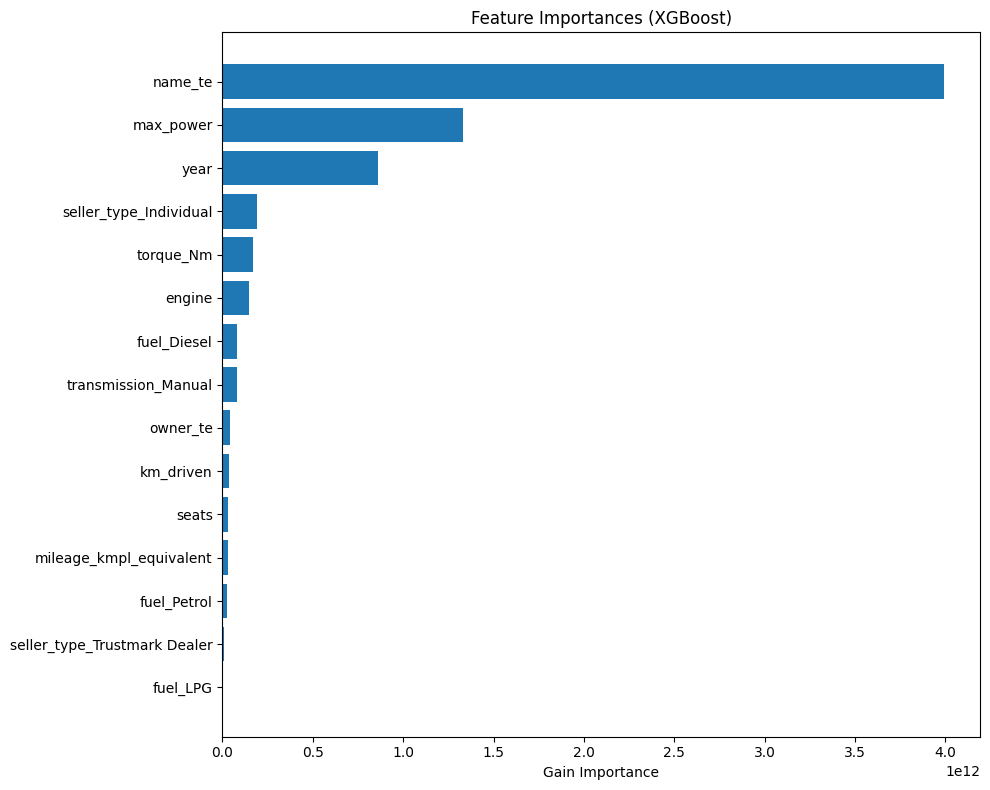

In [16]:
# ===== 9. Feature Importance và Visualization =====
# Trích xuất feature names sau preprocessing
# Lấy booster từ pipeline

# Huấn luyện lại trên toàn bộ train với best all-features hoặc selected features tuỳ bạn
pipeline_imp = build_pipeline(all_features, params={**study_all.best_params, 'tree_method':'hist','random_state':SEED,'n_jobs':-1,'verbosity':0})
pipeline_imp.fit(train_df[all_features], train_df[target_variable])

# Lấy model XGB từ pipeline
xgb_model = pipeline_imp.named_steps['model']

# Lấy importance theo gain (keys f0, f1,...)
raw_imp = xgb_model.get_booster().get_score(importance_type='gain')
# Tạo danh sách feature names thực qua pipeline
pre = pipeline_imp.named_steps['pre']
# 1. target-encoded names
te_names = [col + '_te' for col in all_features if col in te_features]
# 2. one-hot names
ohe = pre.named_transformers_['ohe']
ohe_input = encoded_features
ohe_names = list(ohe.get_feature_names_out(ohe_input))
# 3. remainder passthrough (numeric)
remainder = [col for col in all_features if col in numerical_cols]
# Kết hợp
feature_names = te_names + ohe_names + remainder
# Map raw_imp keys (e.g. 'f0') sang tên thật
mapped_imp = {feature_names[int(k[1:])]: v for k, v in raw_imp.items()}
# Chuyển thành DataFrame và sắp xếp
imp_df = pd.DataFrame({
    'feature': list(mapped_imp.keys()),
    'importance': list(mapped_imp.values())
}).sort_values('importance', ascending=False)

# Vẽ bar chart cho tất cả features
plt.figure(figsize=(10, 8))
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.xlabel('Gain Importance')
plt.title('Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

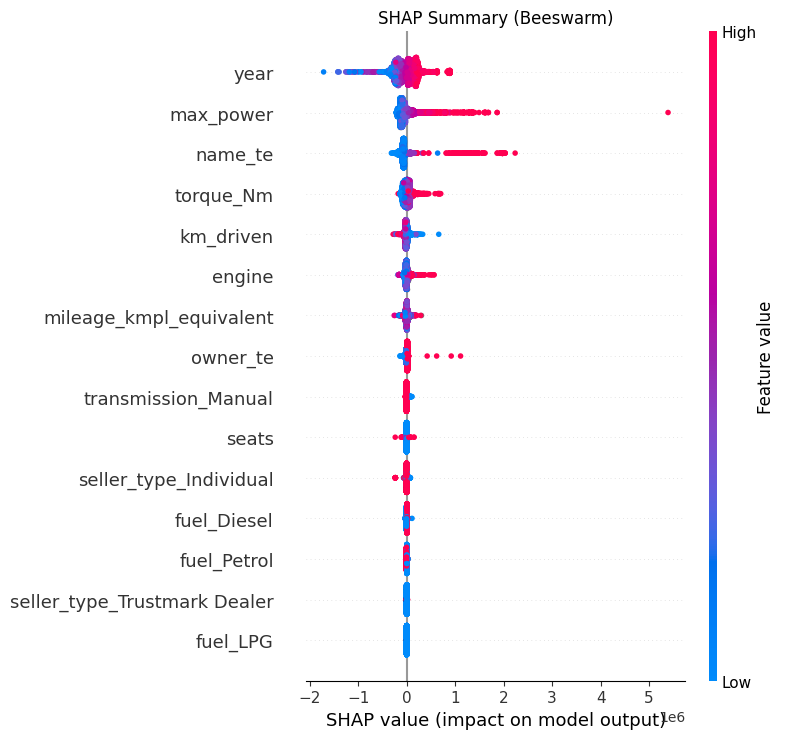

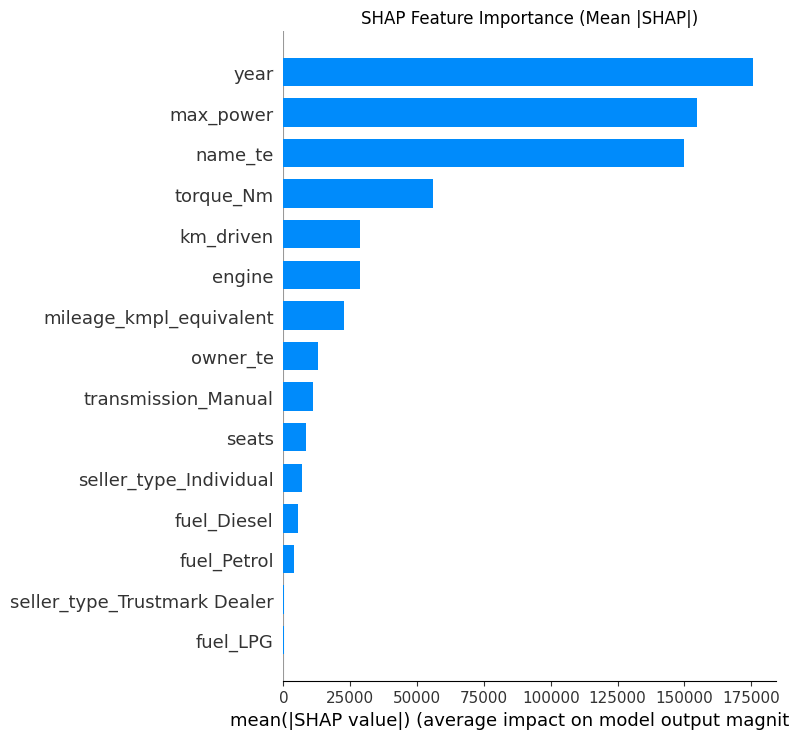

In [19]:
# ===== SHAP Analysis =====
import shap
# Dùng TreeExplainer để lấy SHAP values
explainer = shap.TreeExplainer(xgb_model)
# Tính SHAP values trên toàn bộ dữ liệu đã preprocess
shap_values = explainer.shap_values(X_prepped)

# Vẽ summary plot (beeswarm) với tên thật
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_prepped, feature_names=feature_names, show=False)
plt.title('SHAP Summary (Beeswarm)')
plt.tight_layout()
plt.show()

# Vẽ bar plot tóm tắt mean(|SHAP|)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_prepped, feature_names=feature_names, plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Mean |SHAP|)')
plt.tight_layout()
plt.show()

In [20]:
# ===== 10. Train lại với toàn bộ dữ liệu gốc =====
X_full = df[all_features]
y_full = df[target_variable]

sampler_full = optuna.samplers.TPESampler(seed=SEED)
study_full = optuna.create_study(direction='minimize', sampler=sampler_full)

def objective_full(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'max_depth':    trial.suggest_int('max_depth', 5, 25),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
        'random_state': SEED,
        'n_jobs': 1,
        'tree_method': 'hist'
    }
    pipe = build_pipeline(all_features, params=params)
    rmse = -cross_val_score(pipe, X_full, y_full,
                            scoring='neg_root_mean_squared_error', cv=kf, n_jobs=1).mean()
    return rmse

study_full.optimize(objective_full, n_trials=50, show_progress_bar=True)

print("== Final model with full dataset ==")
print("Best RMSE (CV):", round(study_full.best_value, 2))
print("Best params:", study_full.best_params)

# Train final model on all data
pipe_full_final = build_pipeline(all_features, params={**study_full.best_params, 'random_state':SEED, 'n_jobs':-1, 'tree_method': 'hist'})
pipe_full_final.fit(X_full, y_full)


[I 2025-06-17 20:37:47,002] A new study created in memory with name: no-name-73e1f277-087c-4260-b6ba-e4f0259be629
Best trial: 0. Best value: 147370:   2%|▏         | 1/50 [00:26<21:41, 26.56s/it]

[I 2025-06-17 20:38:13,812] Trial 0 finished with value: 147369.69651110462 and parameters: {'n_estimators': 562, 'max_depth': 24, 'min_child_weight': 8, 'learning_rate': 0.18361096041714062, 'subsample': 0.5780093202212182, 'colsample_bytree': 0.5779972601681014, 'gamma': 0.2904180608409973, 'reg_alpha': 4.330880728874676, 'reg_lambda': 3.005575058716044}. Best is trial 0 with value: 147369.69651110462.


Best trial: 1. Best value: 145808:   4%|▍         | 2/50 [00:33<11:56, 14.93s/it]

[I 2025-06-17 20:38:20,604] Trial 1 finished with value: 145807.64821397758 and parameters: {'n_estimators': 796, 'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.2514083658321223, 'subsample': 0.6061695553391381, 'colsample_bytree': 0.5909124836035503, 'gamma': 0.9170225492671691, 'reg_alpha': 1.5212112147976886, 'reg_lambda': 2.6237821581611893}. Best is trial 1 with value: 145807.64821397758.


Best trial: 2. Best value: 136397:   6%|▌         | 3/50 [00:49<12:12, 15.60s/it]

[I 2025-06-17 20:38:36,991] Trial 2 finished with value: 136397.25089149893 and parameters: {'n_estimators': 602, 'max_depth': 11, 'min_child_weight': 7, 'learning_rate': 0.05045321958909213, 'subsample': 0.6460723242676091, 'colsample_bytree': 0.6831809216468459, 'gamma': 2.28034992108518, 'reg_alpha': 3.925879806965068, 'reg_lambda': 0.9983689107917987}. Best is trial 2 with value: 136397.25089149893.


Best trial: 2. Best value: 136397:   8%|▊         | 4/50 [01:55<27:13, 35.51s/it]

[I 2025-06-17 20:39:42,139] Trial 3 finished with value: 140829.14476635336 and parameters: {'n_estimators': 660, 'max_depth': 17, 'min_child_weight': 1, 'learning_rate': 0.1861880070514171, 'subsample': 0.5852620618436457, 'colsample_bytree': 0.5325257964926398, 'gamma': 4.7444276862666666, 'reg_alpha': 4.828160165372797, 'reg_lambda': 4.041986740582305}. Best is trial 2 with value: 136397.25089149893.


Best trial: 2. Best value: 136397:  10%|█         | 5/50 [02:02<18:55, 25.22s/it]

[I 2025-06-17 20:39:50,019] Trial 4 finished with value: 139008.78514826778 and parameters: {'n_estimators': 513, 'max_depth': 7, 'min_child_weight': 7, 'learning_rate': 0.13764422318448438, 'subsample': 0.5610191174223894, 'colsample_bytree': 0.7475884550556351, 'gamma': 0.17194260557609198, 'reg_alpha': 4.546602010393911, 'reg_lambda': 1.2938999080000846}. Best is trial 2 with value: 136397.25089149893.


Best trial: 2. Best value: 136397:  12%|█▏        | 6/50 [02:30<19:07, 26.09s/it]

[I 2025-06-17 20:40:17,770] Trial 5 finished with value: 142573.60003294537 and parameters: {'n_estimators': 764, 'max_depth': 11, 'min_child_weight': 6, 'learning_rate': 0.1685459810095511, 'subsample': 0.5924272277627636, 'colsample_bytree': 0.9847923138822793, 'gamma': 3.8756641168055728, 'reg_alpha': 4.697494707820946, 'reg_lambda': 4.474136752138244}. Best is trial 2 with value: 136397.25089149893.


Best trial: 2. Best value: 136397:  14%|█▍        | 7/50 [03:52<31:46, 44.33s/it]

[I 2025-06-17 20:41:39,661] Trial 6 finished with value: 138141.4197467369 and parameters: {'n_estimators': 719, 'max_depth': 24, 'min_child_weight': 1, 'learning_rate': 0.0668350301015521, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'gamma': 1.9433864484474102, 'reg_alpha': 1.3567451588694794, 'reg_lambda': 4.143687545759647}. Best is trial 2 with value: 136397.25089149893.


Best trial: 7. Best value: 133713:  16%|█▌        | 8/50 [04:00<22:57, 32.79s/it]

[I 2025-06-17 20:41:47,761] Trial 7 finished with value: 133712.56136500338 and parameters: {'n_estimators': 550, 'max_depth': 10, 'min_child_weight': 6, 'learning_rate': 0.050868025242681164, 'subsample': 0.9010984903770198, 'colsample_bytree': 0.5372753218398854, 'gamma': 4.9344346830025865, 'reg_alpha': 3.861223846483287, 'reg_lambda': 0.993578407670862}. Best is trial 7 with value: 133712.56136500338.


Best trial: 7. Best value: 133713:  18%|█▊        | 9/50 [04:13<18:08, 26.54s/it]

[I 2025-06-17 20:42:00,553] Trial 8 finished with value: 141517.78728366195 and parameters: {'n_estimators': 303, 'max_depth': 22, 'min_child_weight': 8, 'learning_rate': 0.2214120787318863, 'subsample': 0.8856351733429728, 'colsample_bytree': 0.5370223258670452, 'gamma': 1.7923286427213632, 'reg_alpha': 0.5793452976256486, 'reg_lambda': 4.315517129377968}. Best is trial 7 with value: 133712.56136500338.


Best trial: 7. Best value: 133713:  20%|██        | 10/50 [04:50<19:53, 29.85s/it]

[I 2025-06-17 20:42:37,803] Trial 9 finished with value: 136501.7034260606 and parameters: {'n_estimators': 736, 'max_depth': 11, 'min_child_weight': 1, 'learning_rate': 0.10018487329754203, 'subsample': 0.6625916610133735, 'colsample_bytree': 0.864803089169032, 'gamma': 3.1877873567760657, 'reg_alpha': 4.436063712881633, 'reg_lambda': 2.3610746258097466}. Best is trial 7 with value: 133712.56136500338.


Best trial: 7. Best value: 133713:  22%|██▏       | 11/50 [05:46<24:32, 37.74s/it]

[I 2025-06-17 20:43:33,457] Trial 10 finished with value: 144235.33018415232 and parameters: {'n_estimators': 962, 'max_depth': 17, 'min_child_weight': 4, 'learning_rate': 0.015208943928297747, 'subsample': 0.9905354130446519, 'colsample_bytree': 0.8451235367845726, 'gamma': 4.865188803848123, 'reg_alpha': 3.1204176358618274, 'reg_lambda': 0.1989980303850739}. Best is trial 7 with value: 133712.56136500338.


Best trial: 7. Best value: 133713:  24%|██▍       | 12/50 [05:57<18:48, 29.70s/it]

[I 2025-06-17 20:43:44,770] Trial 11 finished with value: 135037.19759721984 and parameters: {'n_estimators': 462, 'max_depth': 11, 'min_child_weight': 4, 'learning_rate': 0.015811958510274414, 'subsample': 0.7678121320177449, 'colsample_bytree': 0.6810261293696235, 'gamma': 2.7090820820154438, 'reg_alpha': 3.035921370166128, 'reg_lambda': 0.6392974642030651}. Best is trial 7 with value: 133712.56136500338.


Best trial: 7. Best value: 133713:  26%|██▌       | 13/50 [06:26<18:13, 29.56s/it]

[I 2025-06-17 20:44:14,004] Trial 12 finished with value: 135649.73458148367 and parameters: {'n_estimators': 407, 'max_depth': 14, 'min_child_weight': 4, 'learning_rate': 0.012060509906043144, 'subsample': 0.7987236171271963, 'colsample_bytree': 0.6611763278872982, 'gamma': 3.5058129769688, 'reg_alpha': 2.9180888291883296, 'reg_lambda': 0.02414033345417299}. Best is trial 7 with value: 133712.56136500338.


Best trial: 7. Best value: 133713:  28%|██▊       | 14/50 [06:35<13:57, 23.27s/it]

[I 2025-06-17 20:44:22,749] Trial 13 finished with value: 146766.5526809439 and parameters: {'n_estimators': 459, 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.29981510720604987, 'subsample': 0.7769884546073322, 'colsample_bytree': 0.7536402630633618, 'gamma': 4.120263521352462, 'reg_alpha': 3.4411475597509966, 'reg_lambda': 1.4825948411874768}. Best is trial 7 with value: 133712.56136500338.


Best trial: 7. Best value: 133713:  30%|███       | 15/50 [06:54<12:51, 22.04s/it]

[I 2025-06-17 20:44:41,935] Trial 14 finished with value: 139615.72329075914 and parameters: {'n_estimators': 348, 'max_depth': 14, 'min_child_weight': 3, 'learning_rate': 0.10282078539960679, 'subsample': 0.8814672343398583, 'colsample_bytree': 0.6145935749953395, 'gamma': 2.793992915216572, 'reg_alpha': 2.255888615914837, 'reg_lambda': 0.7378161415393708}. Best is trial 7 with value: 133712.56136500338.


Best trial: 15. Best value: 133467:  32%|███▏      | 16/50 [07:01<09:49, 17.33s/it]

[I 2025-06-17 20:44:48,332] Trial 15 finished with value: 133467.01043267307 and parameters: {'n_estimators': 475, 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.05608630286892545, 'subsample': 0.8905193220684801, 'colsample_bytree': 0.7598639083640468, 'gamma': 1.0007337483700232, 'reg_alpha': 2.5296974775172734, 'reg_lambda': 1.9147540598918547}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  34%|███▍      | 17/50 [07:11<08:19, 15.14s/it]

[I 2025-06-17 20:44:58,382] Trial 16 finished with value: 135155.06581651498 and parameters: {'n_estimators': 865, 'max_depth': 8, 'min_child_weight': 6, 'learning_rate': 0.07032095546594667, 'subsample': 0.9768165865131958, 'colsample_bytree': 0.788474586944839, 'gamma': 0.9790650371004513, 'reg_alpha': 2.144640709735348, 'reg_lambda': 1.8449329666659289}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  36%|███▌      | 18/50 [07:16<06:31, 12.24s/it]

[I 2025-06-17 20:45:03,850] Trial 17 finished with value: 138356.32185174176 and parameters: {'n_estimators': 628, 'max_depth': 5, 'min_child_weight': 10, 'learning_rate': 0.11729453505557107, 'subsample': 0.8935884495096859, 'colsample_bytree': 0.929743512436532, 'gamma': 1.2586733699231065, 'reg_alpha': 3.7611537876760077, 'reg_lambda': 3.35618483675276}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  38%|███▊      | 19/50 [07:25<05:44, 11.12s/it]

[I 2025-06-17 20:45:12,379] Trial 18 finished with value: 136147.3159030777 and parameters: {'n_estimators': 505, 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.05132305065650825, 'subsample': 0.8350958490071932, 'colsample_bytree': 0.8280219172107683, 'gamma': 1.487336035311304, 'reg_alpha': 1.8832434025607498, 'reg_lambda': 1.9964732415940323}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  40%|████      | 20/50 [08:03<09:38, 19.28s/it]

[I 2025-06-17 20:45:50,662] Trial 19 finished with value: 139148.11954858684 and parameters: {'n_estimators': 558, 'max_depth': 20, 'min_child_weight': 3, 'learning_rate': 0.13523875793990633, 'subsample': 0.7051102112946549, 'colsample_bytree': 0.5038681534411007, 'gamma': 4.061080132164646, 'reg_alpha': 0.7149421430093299, 'reg_lambda': 1.7260454426573788}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  42%|████▏     | 21/50 [08:12<07:47, 16.13s/it]

[I 2025-06-17 20:45:59,458] Trial 20 finished with value: 138803.94885853658 and parameters: {'n_estimators': 404, 'max_depth': 13, 'min_child_weight': 8, 'learning_rate': 0.08178452274897799, 'subsample': 0.9391760588249373, 'colsample_bytree': 0.7367157503911039, 'gamma': 0.6938496971529939, 'reg_alpha': 0.05810480813776486, 'reg_lambda': 4.969213925248544}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  44%|████▍     | 22/50 [08:20<06:25, 13.77s/it]

[I 2025-06-17 20:46:07,723] Trial 21 finished with value: 134069.25170774627 and parameters: {'n_estimators': 458, 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.03732630302148382, 'subsample': 0.8359977904177938, 'colsample_bytree': 0.7062745815220801, 'gamma': 2.727360509223757, 'reg_alpha': 2.7804972312502345, 'reg_lambda': 0.6870153364577292}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  46%|████▌     | 23/50 [08:26<05:11, 11.53s/it]

[I 2025-06-17 20:46:14,037] Trial 22 finished with value: 134299.54898754234 and parameters: {'n_estimators': 402, 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.033483278860295965, 'subsample': 0.8359253029070636, 'colsample_bytree': 0.7988021355133459, 'gamma': 2.327122497128113, 'reg_alpha': 2.5695511172082823, 'reg_lambda': 1.108929789922557}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  48%|████▊     | 24/50 [08:45<05:58, 13.78s/it]

[I 2025-06-17 20:46:33,074] Trial 23 finished with value: 140688.83315989928 and parameters: {'n_estimators': 497, 'max_depth': 16, 'min_child_weight': 6, 'learning_rate': 0.044893575185823806, 'subsample': 0.9312424384721127, 'colsample_bytree': 0.8937292983448513, 'gamma': 3.373093671626421, 'reg_alpha': 2.694637903925983, 'reg_lambda': 0.5365790663871395}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  50%|█████     | 25/50 [08:50<04:34, 10.98s/it]

[I 2025-06-17 20:46:37,507] Trial 24 finished with value: 135755.94545078714 and parameters: {'n_estimators': 567, 'max_depth': 6, 'min_child_weight': 7, 'learning_rate': 0.07487474822378673, 'subsample': 0.84463422740817, 'colsample_bytree': 0.7061263810064461, 'gamma': 4.457457469101827, 'reg_alpha': 3.573056040666318, 'reg_lambda': 2.334353909667364}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  52%|█████▏    | 26/50 [09:08<05:19, 13.30s/it]

[I 2025-06-17 20:46:56,227] Trial 25 finished with value: 138955.867122467 and parameters: {'n_estimators': 668, 'max_depth': 12, 'min_child_weight': 3, 'learning_rate': 0.035856051005201915, 'subsample': 0.7201219900800487, 'colsample_bytree': 0.620071494794409, 'gamma': 1.9082400441591245, 'reg_alpha': 4.110084636833385, 'reg_lambda': 1.3501722713178244}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  54%|█████▍    | 27/50 [09:15<04:21, 11.39s/it]

[I 2025-06-17 20:47:03,152] Trial 26 finished with value: 140154.9908769614 and parameters: {'n_estimators': 464, 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.09258494643279966, 'subsample': 0.9384889530016627, 'colsample_bytree': 0.7787588257864038, 'gamma': 3.0885944858652663, 'reg_alpha': 3.2188770641538875, 'reg_lambda': 0.4830222814988654}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  56%|█████▌    | 28/50 [09:23<03:47, 10.32s/it]

[I 2025-06-17 20:47:10,986] Trial 27 finished with value: 136237.05336907116 and parameters: {'n_estimators': 348, 'max_depth': 10, 'min_child_weight': 2, 'learning_rate': 0.05917881845657878, 'subsample': 0.8040449313148199, 'colsample_bytree': 0.7202432327296192, 'gamma': 3.731688311478307, 'reg_alpha': 1.778218199910182, 'reg_lambda': 0.8550865329080188}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  58%|█████▊    | 29/50 [09:29<03:05,  8.83s/it]

[I 2025-06-17 20:47:16,336] Trial 28 finished with value: 136890.3571540402 and parameters: {'n_estimators': 526, 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.11785165250354206, 'subsample': 0.8617750722135333, 'colsample_bytree': 0.6359049188593258, 'gamma': 0.6191725853279024, 'reg_alpha': 2.420758322739538, 'reg_lambda': 1.6147341546516212}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  60%|██████    | 30/50 [09:38<03:03,  9.15s/it]

[I 2025-06-17 20:47:26,244] Trial 29 finished with value: 134847.11738830904 and parameters: {'n_estimators': 586, 'max_depth': 13, 'min_child_weight': 9, 'learning_rate': 0.033441197478527265, 'subsample': 0.9145240371112212, 'colsample_bytree': 0.578951718966048, 'gamma': 0.0773075231181155, 'reg_alpha': 4.1991922809080675, 'reg_lambda': 3.0012058237569312}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  62%|██████▏   | 31/50 [09:55<03:35, 11.34s/it]

[I 2025-06-17 20:47:42,688] Trial 30 finished with value: 141809.6475585307 and parameters: {'n_estimators': 435, 'max_depth': 15, 'min_child_weight': 6, 'learning_rate': 0.19819906638962292, 'subsample': 0.9597977223447893, 'colsample_bytree': 0.5536913296847445, 'gamma': 1.331892534536396, 'reg_alpha': 3.4021125123262603, 'reg_lambda': 2.133941006983679}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  64%|██████▍   | 32/50 [10:02<03:01, 10.11s/it]

[I 2025-06-17 20:47:49,910] Trial 31 finished with value: 136220.4742542792 and parameters: {'n_estimators': 377, 'max_depth': 9, 'min_child_weight': 5, 'learning_rate': 0.033035779595071334, 'subsample': 0.8295972432943526, 'colsample_bytree': 0.8001707184191874, 'gamma': 2.310701112841051, 'reg_alpha': 2.4373593331736054, 'reg_lambda': 1.1133709290967053}. Best is trial 15 with value: 133467.01043267307.


Best trial: 15. Best value: 133467:  66%|██████▌   | 33/50 [10:08<02:29,  8.80s/it]

[I 2025-06-17 20:47:55,653] Trial 32 finished with value: 139221.13587730896 and parameters: {'n_estimators': 311, 'max_depth': 7, 'min_child_weight': 7, 'learning_rate': 0.022440876518466164, 'subsample': 0.8105368769310622, 'colsample_bytree': 0.8277774424341973, 'gamma': 2.4711396727751946, 'reg_alpha': 2.7773304330515827, 'reg_lambda': 0.31460551982480056}. Best is trial 15 with value: 133467.01043267307.


Best trial: 33. Best value: 133221:  68%|██████▊   | 34/50 [10:16<02:16,  8.54s/it]

[I 2025-06-17 20:48:03,598] Trial 33 finished with value: 133221.35980755457 and parameters: {'n_estimators': 395, 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.0561400535012877, 'subsample': 0.864549992851328, 'colsample_bytree': 0.7689703276346234, 'gamma': 2.922287095621835, 'reg_alpha': 1.2175727723938596, 'reg_lambda': 1.0822618389753877}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  70%|███████   | 35/50 [10:26<02:16,  9.10s/it]

[I 2025-06-17 20:48:13,988] Trial 34 finished with value: 134520.47856654145 and parameters: {'n_estimators': 437, 'max_depth': 12, 'min_child_weight': 6, 'learning_rate': 0.053396798982556434, 'subsample': 0.9014097786318519, 'colsample_bytree': 0.7045527598250891, 'gamma': 2.9149782236046597, 'reg_alpha': 1.1632510815469055, 'reg_lambda': 0.8884394318404935}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  72%|███████▏  | 36/50 [10:36<02:10,  9.35s/it]

[I 2025-06-17 20:48:23,924] Trial 35 finished with value: 137433.12184903913 and parameters: {'n_estimators': 542, 'max_depth': 10, 'min_child_weight': 7, 'learning_rate': 0.08682451382578771, 'subsample': 0.874727206481624, 'colsample_bytree': 0.7616871580239344, 'gamma': 4.300809040695102, 'reg_alpha': 1.9747095124004677, 'reg_lambda': 1.372585695842856}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  74%|███████▍  | 37/50 [10:42<01:48,  8.36s/it]

[I 2025-06-17 20:48:29,969] Trial 36 finished with value: 140935.51220999268 and parameters: {'n_estimators': 604, 'max_depth': 5, 'min_child_weight': 4, 'learning_rate': 0.15057088659570209, 'subsample': 0.7333112298358084, 'colsample_bytree': 0.8888629321658827, 'gamma': 4.542434089428097, 'reg_alpha': 1.5972351559592355, 'reg_lambda': 3.0225686460837355}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  76%|███████▌  | 38/50 [10:54<01:54,  9.53s/it]

[I 2025-06-17 20:48:42,204] Trial 37 finished with value: 142564.5954813925 and parameters: {'n_estimators': 498, 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.11406084921956673, 'subsample': 0.8589552278435157, 'colsample_bytree': 0.9528811911479834, 'gamma': 1.6169044194379572, 'reg_alpha': 4.90927031573191, 'reg_lambda': 1.1121808728560247}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  78%|███████▊  | 39/50 [11:08<01:59, 10.87s/it]

[I 2025-06-17 20:48:56,228] Trial 38 finished with value: 135104.70968503773 and parameters: {'n_estimators': 673, 'max_depth': 12, 'min_child_weight': 7, 'learning_rate': 0.06484117990630678, 'subsample': 0.9650498394982954, 'colsample_bytree': 0.7309978580970372, 'gamma': 3.6956000523263612, 'reg_alpha': 1.0896359791702563, 'reg_lambda': 2.835250276547955}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  80%|████████  | 40/50 [11:12<01:27,  8.79s/it]

[I 2025-06-17 20:49:00,162] Trial 39 finished with value: 134070.19950398794 and parameters: {'n_estimators': 367, 'max_depth': 7, 'min_child_weight': 6, 'learning_rate': 0.05110854697950294, 'subsample': 0.9136259830737694, 'colsample_bytree': 0.647310124033235, 'gamma': 0.44676793892180866, 'reg_alpha': 3.8671119969476497, 'reg_lambda': 3.53423447720972}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  82%|████████▏ | 41/50 [12:26<04:14, 28.25s/it]

[I 2025-06-17 20:50:13,801] Trial 40 finished with value: 141730.0196252168 and parameters: {'n_estimators': 620, 'max_depth': 18, 'min_child_weight': 2, 'learning_rate': 0.1330193173883685, 'subsample': 0.7721805695686496, 'colsample_bytree': 0.6894254861494677, 'gamma': 2.0899819297172, 'reg_alpha': 1.5145747577479702, 'reg_lambda': 2.0654976495722592}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  84%|████████▍ | 42/50 [12:29<02:45, 20.69s/it]

[I 2025-06-17 20:50:16,858] Trial 41 finished with value: 138161.96552421738 and parameters: {'n_estimators': 354, 'max_depth': 6, 'min_child_weight': 6, 'learning_rate': 0.04691986867006971, 'subsample': 0.9992785441126418, 'colsample_bytree': 0.6583507460615664, 'gamma': 0.5824039482660699, 'reg_alpha': 3.785527604633441, 'reg_lambda': 3.4050793456622084}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  86%|████████▌ | 43/50 [12:33<01:49, 15.63s/it]

[I 2025-06-17 20:50:20,671] Trial 42 finished with value: 135544.88359696622 and parameters: {'n_estimators': 383, 'max_depth': 8, 'min_child_weight': 6, 'learning_rate': 0.07359296805217122, 'subsample': 0.9223119402615273, 'colsample_bytree': 0.6078762278813871, 'gamma': 0.9510575352699372, 'reg_alpha': 3.8916688391422762, 'reg_lambda': 0.33481956859562934}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  88%|████████▊ | 44/50 [12:37<01:13, 12.18s/it]

[I 2025-06-17 20:50:24,817] Trial 43 finished with value: 136340.14363393543 and parameters: {'n_estimators': 440, 'max_depth': 7, 'min_child_weight': 5, 'learning_rate': 0.059035811521811477, 'subsample': 0.9038065387128854, 'colsample_bytree': 0.5651866841116752, 'gamma': 0.4127021620241731, 'reg_alpha': 4.547847975310245, 'reg_lambda': 3.791170153178858}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  90%|█████████ | 45/50 [12:46<00:55, 11.10s/it]

[I 2025-06-17 20:50:33,409] Trial 44 finished with value: 133330.70318816387 and parameters: {'n_estimators': 475, 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.02505408933614222, 'subsample': 0.8659988566690433, 'colsample_bytree': 0.6458666840106734, 'gamma': 0.27934897772086664, 'reg_alpha': 3.304914996251093, 'reg_lambda': 0.019810081045667283}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  92%|█████████▏| 46/50 [12:57<00:44, 11.06s/it]

[I 2025-06-17 20:50:44,373] Trial 45 finished with value: 136296.4659905218 and parameters: {'n_estimators': 480, 'max_depth': 11, 'min_child_weight': 4, 'learning_rate': 0.024891583951842065, 'subsample': 0.8666247419267125, 'colsample_bytree': 0.7670535727380271, 'gamma': 0.028853606854115754, 'reg_alpha': 3.2596904543262646, 'reg_lambda': 0.0801207565719328}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  94%|█████████▍| 47/50 [13:08<00:33, 11.27s/it]

[I 2025-06-17 20:50:56,131] Trial 46 finished with value: 135094.8957621096 and parameters: {'n_estimators': 542, 'max_depth': 10, 'min_child_weight': 4, 'learning_rate': 0.014951776127554856, 'subsample': 0.8162138952632036, 'colsample_bytree': 0.511684950844334, 'gamma': 2.53741977556381, 'reg_alpha': 3.581604068295502, 'reg_lambda': 0.6872251492300603}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  96%|█████████▌| 48/50 [13:37<00:33, 16.62s/it]

[I 2025-06-17 20:51:25,246] Trial 47 finished with value: 146696.97988989452 and parameters: {'n_estimators': 421, 'max_depth': 12, 'min_child_weight': 3, 'learning_rate': 0.2821170399122983, 'subsample': 0.8493335206429434, 'colsample_bytree': 0.6833062001632639, 'gamma': 1.14862134926338, 'reg_alpha': 2.90130982611002, 'reg_lambda': 0.4695037724268038}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221:  98%|█████████▊| 49/50 [13:47<00:14, 14.47s/it]

[I 2025-06-17 20:51:34,696] Trial 48 finished with value: 141509.33244696076 and parameters: {'n_estimators': 315, 'max_depth': 13, 'min_child_weight': 5, 'learning_rate': 0.23220973734221795, 'subsample': 0.8830795489687024, 'colsample_bytree': 0.5936193743119749, 'gamma': 0.28211692666379795, 'reg_alpha': 2.1897579780552983, 'reg_lambda': 0.9817866940417946}. Best is trial 33 with value: 133221.35980755457.


Best trial: 33. Best value: 133221: 100%|██████████| 50/50 [13:52<00:00, 16.66s/it]


[I 2025-06-17 20:51:40,149] Trial 49 finished with value: 135834.22069857022 and parameters: {'n_estimators': 475, 'max_depth': 8, 'min_child_weight': 4, 'learning_rate': 0.04204190462199748, 'subsample': 0.7761025258482941, 'colsample_bytree': 0.7473328207056257, 'gamma': 3.284049857684868, 'reg_alpha': 2.99004231925309, 'reg_lambda': 0.021096572817376}. Best is trial 33 with value: 133221.35980755457.
== Final model with full dataset ==
Best RMSE (CV): 133221.36
Best params: {'n_estimators': 395, 'max_depth': 10, 'min_child_weight': 5, 'learning_rate': 0.0561400535012877, 'subsample': 0.864549992851328, 'colsample_bytree': 0.7689703276346234, 'gamma': 2.922287095621835, 'reg_alpha': 1.2175727723938596, 'reg_lambda': 1.0822618389753877}


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('te',
                                                  TargetEncoderSmooth(cols=['name',
                                                                            'owner']),
                                                  ['name', 'owner']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['fuel', 'seller_type',
                                                   'transmission'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_byno...
                              gamma=2.922287095621835, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.0561400535012877, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=10,
                              max_leaves=None, min_child_weight=5, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=395, n_jobs=-1,
                              num_parallel_tree=None, ...))])

In [ ]:
# ===== ĐỌC DỮ LIỆU MỚI=====
df_new = pd.read_excel("realdata_clean.xlsx", sheet_name=0, engine="openpyxl")
df_new.drop(columns=['mileage', 'torque', 'mileage_numeric', 'mileage_unit', 'torque_unit_extracted'], inplace=True)

In [22]:
df_new

,id,name,year,km_driven,fuel,seller_type,transmission,owner,engine,max_power,seats,mileage_kmpl_equivalent,torque_Nm
0,1,Skoda,2016,11000,Petrol,Dealer,Automatic,First Owner,1598.0,103.50,5.0,14.30,153.00
1,2,Honda,2017,35000,Petrol,Individual,Manual,First Owner,1497.0,117.30,5.0,17.80,145.00
2,3,Hyundai,2014,80000,Petrol,Individual,Manual,First Owner,1197.0,82.00,5.0,19.10,114.00
3,4,Mahindra,2014,145241,Diesel,Individual,Manual,First Owner,2179.0,120.00,7.0,12.05,290.00
4,5,Ford,2015,92651,Diesel,Dealer,Manual,First Owner,1498.0,98.96,5.0,21.70,215.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2123,2124,Hyundai,2020,2000,Petrol,Dealer,Manual,First Owner,1197.0,81.86,5.0,20.70,113.75
2124,2125,Maruti,2018,100000,Diesel,Individual,Manual,Second Owner,1248.0,74.02,5.0,28.40,190.00
2125,2126,Tata,2011,172000,Diesel,Individual,Manual,Second Owner,1396.0,52.80,5.0,17.88,85.00
2126,2127,Hyundai,2017,47000,Diesel,Individual,Manual,Second Owner,1582.0,126.20,5.0,19.67,259.90


In [23]:
# ===== 11. DỰ BÁO CHO DỮ LIỆU MỚI =====
# Lưu ý: df_new phải chứa đầy đủ các cột đặc trưng như trong all_features
X_new = df_new[all_features]
y_pred_new = pipe_full_final.predict(X_new)

# Tạo DataFrame kết quả
df_pred = pd.DataFrame({
    'Id': df_new['id'],
    'Predicted': y_pred_new
})

# Hiển thị kết quả
print(df_pred.head())

   Id     Predicted
0   1  644907.12500
1   2  837010.50000
2   3  407949.21875
3   4  569987.75000
4   5  580567.68750


In [ ]:
# Ghi ra file CSV
df_pred.to_csv("predicted_prices.csv", index=False)